# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (uti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_uti_admitted', 'duration_uti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    covariates_betas.covariate = covariates_betas.covariate.str.replace("[","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("]","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("T.","_")

    # save hazard ratios
    covariates_betas.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    covariates_betas.covariate = covariates_betas.covariate.str.replace("[","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("]","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("T.","_")
    covariates_betas.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    covariates_betas.covariate = covariates_betas.covariate.str.replace("[","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("]","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("T.","_")
    covariates_betas.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    covariates_betas.covariate = covariates_betas.covariate.str.replace("[","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("]","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("T.","_")
    covariates_betas.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    covariates_betas.covariate = covariates_betas.covariate.str.replace("[","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("]","")
    covariates_betas.covariate = covariates_betas.covariate.str.replace("T.","_")
    covariates_betas.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_uti/data_uti_record_cph_uti.txt", "w")
a.write("")
a.writelines(['data_uti_1 #with a record, #with no record: %.0f' % (data['uti_date_1'].notna().sum()), ', %.0f' % (data['uti_date_1'].isna().sum()),
              '\ndata_uti_2 #with a record, #with no record: %.0f' % (data['uti_date_2'].notna().sum()), ', %.0f' % (data['uti_date_2'].isna().sum()),
              '\ndata_uti_3 #with a record, #with no record: %.0f' % (data['uti_date_3'].notna().sum()), ', %.0f' % (data['uti_date_3'].isna().sum()),
              '\ndata_uti_4 #with a record, #with no record: %.0f' % (data['uti_date_4'].notna().sum()), ', %.0f' % (data['uti_date_4'].isna().sum()),
              '\ndata_uti_5 #with a record, #with no record: %.0f' % (data['uti_date_5'].notna().sum()), ', %.0f' % (data['uti_date_5'].isna().sum()),
              '\ndata_uti_6 #with a record, #with no record: %.0f' % (data['uti_date_6'].notna().sum()), ', %.0f' % (data['uti_date_6'].isna().sum()),
              '\ndata_uti_7 #with a record, #with no record: %.0f' % (data['uti_date_7'].notna().sum()), ', %.0f' % (data['uti_date_7'].isna().sum()),
              '\ndata_uti_8 #with a record, #with no record: %.0f' % (data['uti_date_8'].notna().sum()), ', %.0f' % (data['uti_date_8'].isna().sum()),
              '\ndata_uti_9 #with a record, #with no record: %.0f' % (data['uti_date_9'].notna().sum()), ', %.0f' % (data['uti_date_9'].isna().sum()),
              '\ndata_uti_10 #with a record, #with no record: %.0f' % (data['uti_date_10'].notna().sum()), ', %.0f' % (data['uti_date_10'].isna().sum()),
              '\ndata_uti_11 #with a record, #with no record: %.0f' % (data['uti_date_11'].notna().sum()), ', %.0f' % (data['uti_date_11'].isna().sum()),
              '\ndata_uti_12 #with a record, #with no record: %.0f' % (data['uti_date_12'].notna().sum()), ', %.0f' % (data['uti_date_12'].isna().sum()),
              '\ndata_uti_13 #with a record, #with no record: %.0f' % (data['uti_date_13'].notna().sum()), ', %.0f' % (data['uti_date_13'].isna().sum()),
              '\ndata_uti_14 #with a record, #with no record: %.0f' % (data['uti_date_14'].notna().sum()), ', %.0f' % (data['uti_date_14'].isna().sum()),
              '\ndata_uti_15 #with a record, #with no record: %.0f' % (data['uti_date_15'].notna().sum()), ', %.0f' % (data['uti_date_15'].isna().sum()),
              '\ndata_uti_16 #with a record, #with no record: %.0f' % (data['uti_date_16'].notna().sum()), ', %.0f' % (data['uti_date_16'].isna().sum()),
              '\ndata_uti_17 #with a record, #with no record: %.0f' % (data['uti_date_17'].notna().sum()), ', %.0f' % (data['uti_date_17'].isna().sum()),
              '\ndata_uti_18 #with a record, #with no record: %.0f' % (data['uti_date_18'].notna().sum()), ', %.0f' % (data['uti_date_18'].isna().sum()),
              '\ndata_uti_19 #with a record, #with no record: %.0f' % (data['uti_date_19'].notna().sum()), ', %.0f' % (data['uti_date_19'].isna().sum()),
              '\ndata_uti_20 #with a record, #with no record: %.0f' % (data['uti_date_20'].notna().sum()), ', %.0f' % (data['uti_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37086
1.0     36848
2.0     33172
3.0     24767
4.0     15065
6.0     12394
7.0      9850
5.0      8275
8.0      8174
9.0      5627
10.0     3292
11.0     1869
12.0     1358
13.0      861
14.0      613
15.0      370
16.0      175
17.0      108
18.0       57
19.0       27
20.0        7
21.0        3
23.0        1
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(360156, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] #gp_cons_uti
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length of data_uti: {len(data_uti)}')

min date: 2019-01
max date: 2022-11
length of data_uti: 360156


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

print(data_uti['season'].value_counts())
print(f'\nmin date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length: {len(data_uti)}')

summer    93683
spring    93385
winter    83482
autumn    69884
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 340434


In [24]:
# data_uti = data_uti[data_uti['date'] <= '2019-12']
# data_uti = data_uti[(data_uti['date'] >= '2020-03') & (data_uti['date']<= '2021-03')]
# data_uti = data_uti[data_uti['date'] >= '2021-04']
# print(f'min date: {data_uti.date.min()}')
# print(f'max date: {data_uti.date.max()}')

In [ ]:
#add period variable
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    238147
Name: event_uti_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days #gp_cons_uti
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1
# data_uti['event_uti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]
data_uti['delta_uti_admitted'].value_counts()

19.0      95
109.0     91
78.0      88
40.0      87
220.0     86
          ..
1344.0     1
1346.0     1
1325.0     1
1322.0     1
1404.0     1
Name: delta_uti_admitted, Length: 1397, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_died'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_deregistered'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_uti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

286811

In [28]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)
data_uti['event_uti_admitted'].value_counts()

0.0    289745
1.0      2237
Name: event_uti_admitted, dtype: int64

In [29]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30
data_uti['duration_uti_admitted'].value_counts()

30.0    289813
19.0        95
7.0         83
20.0        80
9.0         80
18.0        79
13.0        79
0.0         78
16.0        78
21.0        75
24.0        75
17.0        74
29.0        74
14.0        73
26.0        72
23.0        72
1.0         72
12.0        72
2.0         71
11.0        70
25.0        70
22.0        69
27.0        68
6.0         68
5.0         67
8.0         67
15.0        66
4.0         64
3.0         64
28.0        57
10.0        57
Name: duration_uti_admitted, dtype: int64

In [30]:
# give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1
data_uti['event_uti_admitted'].value_counts()

0.0    289737
1.0      2245
Name: event_uti_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

In [32]:
# data_uti[data_uti['duration_uti_admitted']==0][['delta_uti_admitted', 'uti_date', 'gp_cons_uti', 'admitted_uti_date', 'delta_uti_admitted', 'delta_admitted_died_deregistered', 'event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[151:200, ['event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[201:250, ['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])
data_uti[['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])

,event_uti_admitted,duration_uti_admitted
26678,1.0,1.0
171964,1.0,1.0
266420,1.0,1.0
60280,1.0,1.0
88431,1.0,1.0
...,...,...
120568,0.0,30.0
120567,0.0,30.0
120566,0.0,30.0
120574,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_uti['age'][data_uti['age'] < 0] = np.nan
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_uti = data_uti[~(data_uti['age'] < 18)]  
print(f'Min age: {data_uti.age.min()}')

## remove died cases
#data_uti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
# replace 0s with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_uti['region_imp'] = data_uti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_uti.region.isnull().sum()}')
    data_uti = data_uti[data_uti['region'].notna()]

print(f'Cound of missing values in variable region: {data_uti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_uti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35387
South East                  17933
South West                  17902
North East                  17843
East                        17745
East Midlands               17611
Yorkshire and The Humber    17560
West Midlands               17554
North West                  17357
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_uti.antibacterial_brit.mean():.3f}')
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)
    # data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_uti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 5
Mean of antibacterial_brit values before changing NAN to zeros: 1.254

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.254


In [37]:
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_uti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_uti.ethnicity.value_counts()}')
    # data_uti['ethnicity'] = data_uti['ethnicity'].astype(str)
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_uti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_uti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44634
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    105741
3.0     13440
5.0     13077
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    105741
0.0     44634
3.0     13440
5.0     13077
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_uti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_uti.smoking_status.value_counts()}')
    # data_uti['smoking_status'] = data_uti['smoking_status'].astype(str)
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_uti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_uti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73440
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    68871
3.0    23019
2.0    11562
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73440
1.0    68871
3.0    23019
2.0    11562
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_uti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_uti.imd.value_counts()}')
    # data_uti['imd'] = data_uti['imd'].astype(str)
    data_uti['imd'] = data_uti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_uti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_uti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    34163
1    33609
4    33551
2    33422
3    33337
0     8810
Name: imd, dtype: int64


In [40]:
data_uti['bmi_cat'] = 5
col_bmi_cat = data_uti.columns.get_loc('bmi_cat')

col_sex = data_uti.columns.get_loc('sex')
col_age = data_uti.columns.get_loc('age')
col_bmi = data_uti.columns.get_loc('bmi')

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, col_bmi] >= 30:
        data_uti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_uti.iat[idx, col_bmi] >= 25) and (data_uti.iat[idx, col_bmi] < 30):
        data_uti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_uti.iat[idx, col_bmi] >= 18.5) and (data_uti.iat[idx, col_bmi] < 25):
        data_uti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_uti.iat[idx, col_bmi] < 18.5:
        data_uti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_uti['bmi_cat'].value_counts()

1    91820
5    45054
2    19930
3    14256
4     5832
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_uti.bmi_cat.value_counts()}')
    # data_uti['bmi_cat'] = data_uti['bmi_cat'].astype(str)
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_uti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91820
5    45054
2    19930
3    14256
4     5832
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])

#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)
data_uti['ab_type_cat'].value_counts()

no             159183
0               14167
other            2152
Amoxicillin      1036
Doxycycline       354
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})
data_uti['ab_type_cat'].value_counts()

no             159183
other           16319
Amoxicillin      1036
Doxycycline       354
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_uti['CCI_cat'].value_counts()

low          61696
medium       35273
very_low     32783
very_high    28751
high         18389
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)
data_uti['antibacterial_brit'].max()

data_uti['antibacterial_brit_cat'] = pd.cut(data_uti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_uti['antibacterial_brit_cat'].value_counts()

low       102285
high       44339
medium     30268
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

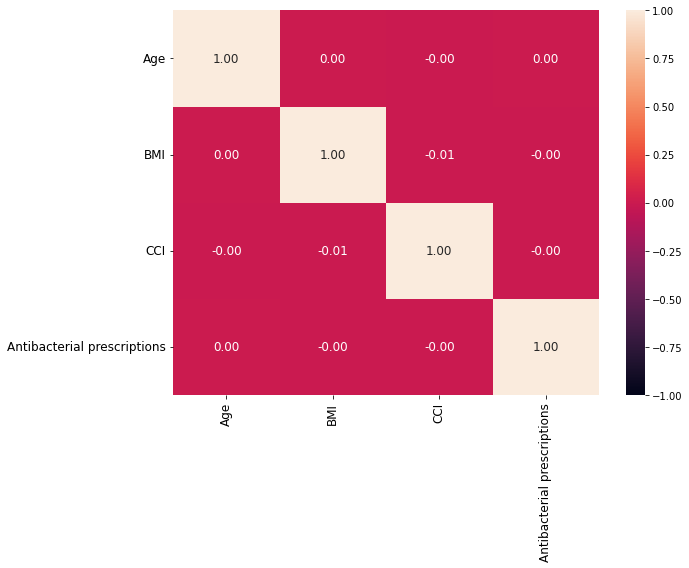

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

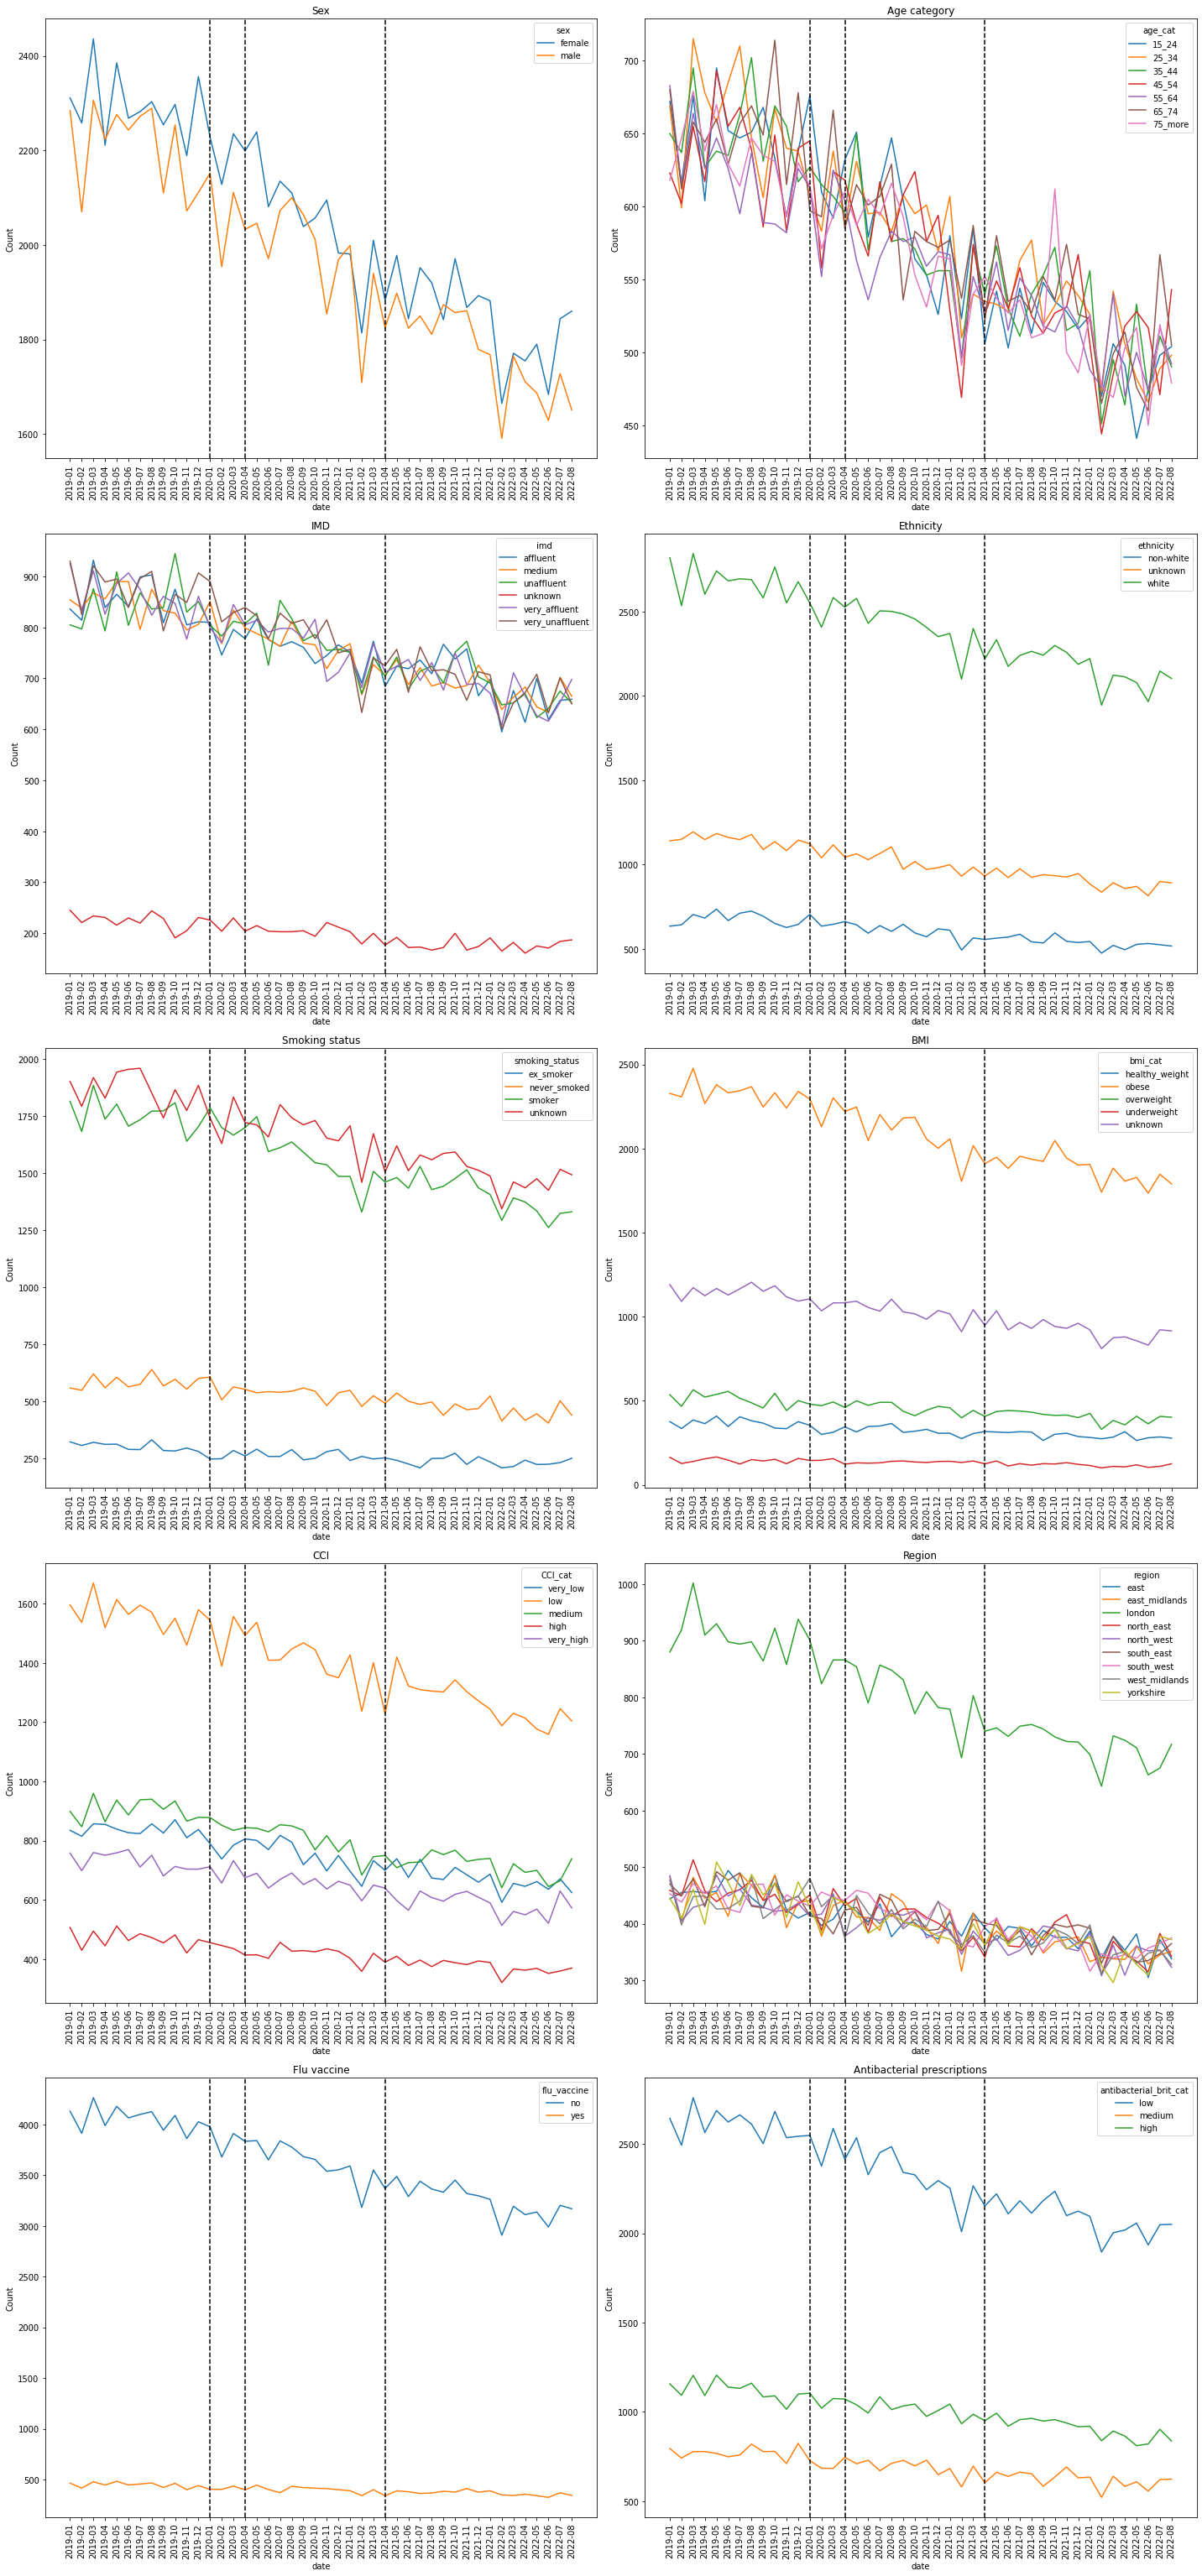

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_uti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_uti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_uti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_uti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_uti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_uti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_uti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_uti, 'region', 'Region', axes[3,1])
create_lineplot(data_uti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_uti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of uti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cat_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of uti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                       'event_uti_admitted', 'duration_uti_admitted'
                        ]]

data_uti.shape

(176892, 17)

In [50]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_uti_incdt_abtype_0 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_incdt_abtype_1 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_incdt_abtype_2 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_incdt_abtype_3 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]
# data_uti_prevl_abtype_0 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_prevl_abtype_1 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_prevl_abtype_2 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_prevl_abtype_3 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_uti_incdt_abs = data_uti_incdt[data_uti_incdt['uti_ab_date'] == 1]
# data_uti_prevl_abs = data_uti_prevl[data_uti_prevl['uti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()] #gp_cons_uti_ab
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

print(f'shape of data_uti_incdt: {data_uti_incdt.shape}')
print(f'shape of data_uti_prevl: {data_uti_prevl.shape}')
print(f'shape of data_uti_no_abs_incdt: {data_uti_no_abs_incdt.shape}')
print(f'shape of data_uti_abs_incdt: {data_uti_abs_incdt.shape}')
print(f'shape of data_uti_no_abs_prevl: {data_uti_no_abs_prevl.shape}')
print(f'shape of data_uti_abs_prevl: {data_uti_abs_prevl.shape}')
print(f'\nvalue counts of data_uti_no_abs_incdt: \n{data_uti_no_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_incdt: \n{data_uti_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_no_abs_prevl: \n{data_uti_no_abs_prevl.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_prevl: \n{data_uti_abs_prevl.event_uti_admitted.value_counts()}')

shape of data_uti_incdt: (159291, 17)
shape of data_uti_prevl: (17601, 17)
shape of data_uti_no_abs_incdt: (143365, 17)
shape of data_uti_abs_incdt: (15926, 17)
shape of data_uti_no_abs_prevl: (15818, 17)
shape of data_uti_abs_prevl: (1783, 17)

value counts of data_uti_no_abs_incdt: 
0.0    142288
1.0      1077
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_incdt: 
0.0    15812
1.0      114
Name: event_uti_admitted, dtype: int64
value counts of data_uti_no_abs_prevl: 
0.0    15697
1.0      121
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_prevl: 
0.0    1769
1.0      14
Name: event_uti_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 107523 total observations, 106703 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 107523
number of events observed = 820
   partial log-likelihood = -9472.55
         time fit was run = 2022-11-17 16:21:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.27       1.31       0.10             0.06             0.47                 1.07                 1.61
CCI_cat[T.medium]                0.15       1.16       0.12            -0.08             0.38                 0.92                 1.47
CCI_cat[T.high]                  0.31       1.37       0.13             0.05             0.58                 1.05                 1.78
CCI_cat[T.very_high]             0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
age_cat[T.25_34]                 0.07       1.08       0.13            -0.19             0.34                 0.83                 1.40
age_cat[T.35_44]                 0.08       1.08       0.13            -0.19             0.34                 0.83                 1.40
age_cat[T.45_54]                -0.11       0.90       0.14            -0.38             0.17                 0.68                 1.18
age_cat[T.55_64]                 0.26       1.30       0.13             0.00             0.51                 1.00                 1.67
age_cat[T.65_74]                 0.12       1.13       0.13            -0.14             0.38                 0.87                 1.46
age_cat[T.75_more]               0.19       1.20       0.13            -0.07             0.44                 0.93                 1.56
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
bmi_cat[T.obese]                 0.08       1.08       0.13            -0.18             0.35                 0.83                 1.41
bmi_cat[T.overweight]            0.13       1.14       0.16            -0.19             0.44                 0.83                 1.56
bmi_cat[T.underweight]           0.08       1.08       0.23            -0.37             0.52                 0.69                 1.69
bmi_cat[T.unknown]              -0.02       0.98       0.15            -0.30             0.27                 0.74                 1.31
ethnicity[T.unknown]             0.25       1.28       0.12             0.01             0.49                 1.01                 1.63
ethnicity[T.white]               0.26       1.30       0.11             0.05             0.48                 1.05                 1.62
flu_vaccine[T.yes]              -0.31       0.73       0.13            -0.57            -0.05                 0.56                 0.95
imd[T.medium]                   -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
imd[T.unaffluent]               -0.19       0.82       0.11            -0.42             0.03                 0.66                 1.03
imd[T.unknown]                  -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.38
imd[T.very_affluent]            -0.05       0.95       0.11            -0.26             0.17                 0.77                 1.18
imd[T.very_unaffluent]          -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
region[T.east_midlands]          0.03       1.03       0.16            -0.28             0.33                 0.76                 1.40
region[T.london]                 0.17       1.19       0.13        

12756


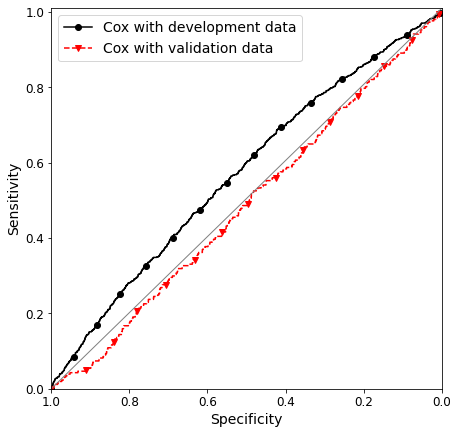

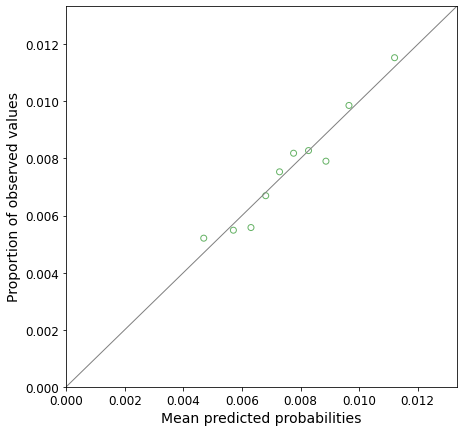

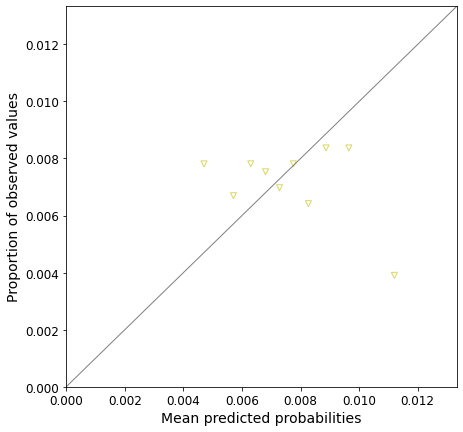

In [52]:
#data prep
data, data_uti_no_abs_incdt_enc = cox_data_prep(data_uti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_incdt', data_uti_no_abs_incdt)

try:
    #build cox model 
    cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test = cox_model_build('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_incdt.csv', data_uti_no_abs_incdt_enc, data_uti_no_abs_incdt, 'sum_betas_cph_uti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_incdt, 'event_uti_admitted', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, 'event_uti_admitted', data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_incdt_train.jpg', 'calibration_cph_uti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_incdt, 'uti', 'no_abs_incdt', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident uti with antibiotics

<lifelines.CoxPHFitter: fitted with 11944 total observations, 11857 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 11944
number of events observed = 87
   partial log-likelihood = -794.95
         time fit was run = 2022-11-17 16:21:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.33            -0.59             0.68                 0.55                 1.98
CCI_cat[T.medium]               -0.07       0.93       0.38            -0.81             0.67                 0.44                 1.96
CCI_cat[T.high]                  0.25       1.29       0.40            -0.54             1.04                 0.58                 2.84
CCI_cat[T.very_high]             0.37       1.45       0.35            -0.32             1.07                 0.73                 2.90
age_cat[T.25_34]                -0.09       0.92       0.42            -0.91             0.73                 0.40                 2.08
age_cat[T.35_44]                -0.22       0.80       0.43            -1.06             0.62                 0.35                 1.86
age_cat[T.45_54]                 0.15       1.16       0.39            -0.62             0.92                 0.54                 2.51
age_cat[T.55_64]                -0.18       0.84       0.43            -1.02             0.66                 0.36                 1.94
age_cat[T.65_74]                -0.04       0.96       0.41            -0.84             0.76                 0.43                 2.14
age_cat[T.75_more]               0.42       1.53       0.37            -0.31             1.16                 0.73                 3.18
antibacterial_brit               0.06       1.06       0.07            -0.09             0.20                 0.91                 1.22
bmi_cat[T.obese]                 0.76       2.14       0.60            -0.41             1.93                 0.66                 6.90
bmi_cat[T.overweight]            0.77       2.17       0.67            -0.53             2.08                 0.59                 8.03
bmi_cat[T.underweight]           0.59       1.80       0.91            -1.20             2.38                 0.30                10.80
bmi_cat[T.unknown]               1.14       3.11       0.61            -0.05             2.32                 0.95                10.20
ethnicity[T.unknown]             0.81       2.24       0.46            -0.10             1.71                 0.91                 5.54
ethnicity[T.white]               0.89       2.42       0.43             0.04             1.73                 1.05                 5.62
flu_vaccine[T.yes]              -0.10       0.90       0.37            -0.83             0.63                 0.44                 1.87
imd[T.medium]                    0.17       1.18       0.34            -0.50             0.84                 0.61                 2.31
imd[T.unaffluent]                0.03       1.03       0.35            -0.65             0.72                 0.52                 2.05
imd[T.unknown]                   0.50       1.64       0.48            -0.44             1.44                 0.64                 4.20
imd[T.very_affluent]            -0.45       0.64       0.40            -1.24             0.34                 0.29                 1.40
imd[T.very_unaffluent]           0.18       1.20       0.34            -0.48             0.85                 0.62                 2.34
region[T.east_midlands]         -0.22       0.80       0.67            -1.54             1.09                 0.22                 2.99
region[T.london]                 0.86       2.36       0.49            -

12758


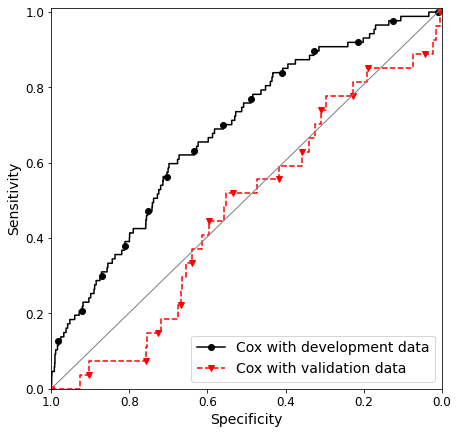

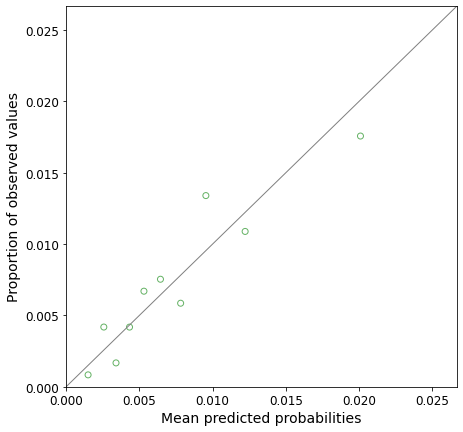

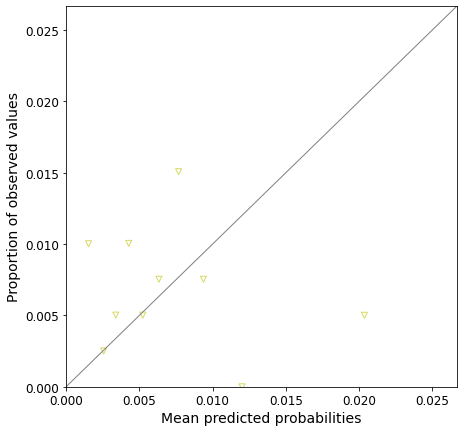

In [53]:
#data prep
data, data_uti_abs_incdt_enc = cox_data_prep(data_uti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_incdt', data_uti_abs_incdt)

try:
    #build cox model 
    cph_uti_abs_incdt, data_uti_abs_incdt_train, data_uti_abs_incdt_test = cox_model_build('uti', 'abs_incdt', data_uti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_incdt.csv', data_uti_abs_incdt_enc, data_uti_abs_incdt, 'sum_betas_cph_uti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_incdt, 'event_uti_admitted', data_uti_abs_incdt_train, data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_incdt, data_uti_abs_incdt_train, 'event_uti_admitted', data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_incdt_train.jpg', 'calibration_cph_uti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_incdt, 'uti', 'abs_incdt', data_uti_abs_incdt_train, data_uti_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11863 total observations, 11772 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 11863
number of events observed = 91
   partial log-likelihood = -839.70
         time fit was run = 2022-11-17 16:21:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.30            -0.78             0.41                 0.46                 1.51
CCI_cat[T.medium]               -0.10       0.90       0.34            -0.77             0.56                 0.46                 1.75
CCI_cat[T.high]                 -0.02       0.98       0.39            -0.79             0.76                 0.45                 2.13
CCI_cat[T.very_high]             0.26       1.30       0.33            -0.39             0.91                 0.68                 2.47
age_cat[T.25_34]                 0.31       1.36       0.42            -0.52             1.14                 0.60                 3.11
age_cat[T.35_44]                 0.12       1.13       0.44            -0.74             0.98                 0.48                 2.66
age_cat[T.45_54]                 0.26       1.30       0.43            -0.58             1.10                 0.56                 3.02
age_cat[T.55_64]                 0.40       1.49       0.41            -0.40             1.20                 0.67                 3.33
age_cat[T.65_74]                 0.33       1.39       0.41            -0.48             1.14                 0.62                 3.14
age_cat[T.75_more]               0.51       1.66       0.40            -0.28             1.30                 0.75                 3.67
antibacterial_brit               0.09       1.09       0.07            -0.05             0.23                 0.95                 1.26
bmi_cat[T.obese]                -0.62       0.54       0.33            -1.26             0.02                 0.28                 1.02
bmi_cat[T.overweight]           -0.76       0.47       0.46            -1.66             0.14                 0.19                 1.15
bmi_cat[T.underweight]          -1.71       0.18       1.04            -3.75             0.33                 0.02                 1.39
bmi_cat[T.unknown]              -0.41       0.66       0.35            -1.10             0.27                 0.33                 1.31
ethnicity[T.unknown]            -0.10       0.91       0.33            -0.74             0.55                 0.48                 1.73
ethnicity[T.white]              -0.18       0.84       0.29            -0.76             0.40                 0.47                 1.49
flu_vaccine[T.yes]               0.12       1.12       0.34            -0.54             0.77                 0.58                 2.17
imd[T.medium]                    0.42       1.52       0.37            -0.31             1.15                 0.73                 3.16
imd[T.unaffluent]                0.86       2.36       0.35             0.18             1.54                 1.19                 4.66
imd[T.unknown]                   0.28       1.32       0.58            -0.85             1.41                 0.43                 4.11
imd[T.very_affluent]             0.06       1.07       0.40            -0.72             0.85                 0.49                 2.34
imd[T.very_unaffluent]           0.35       1.42       0.38            -0.39             1.09                 0.68                 2.97
region[T.east_midlands]         -0.07       0.93       0.42            -0.89             0.75                 0.41                 2.12
region[T.london]                -0.34       0.71       0.38            -

12765


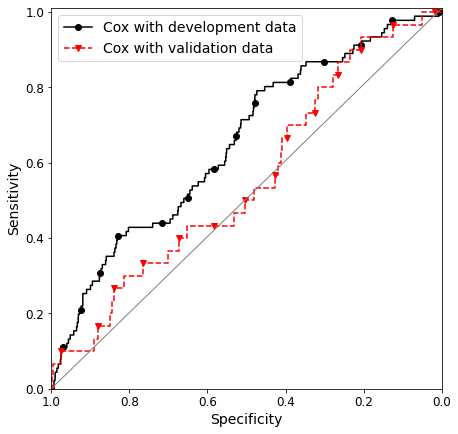

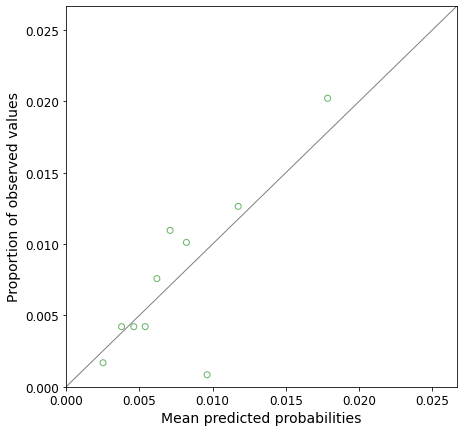

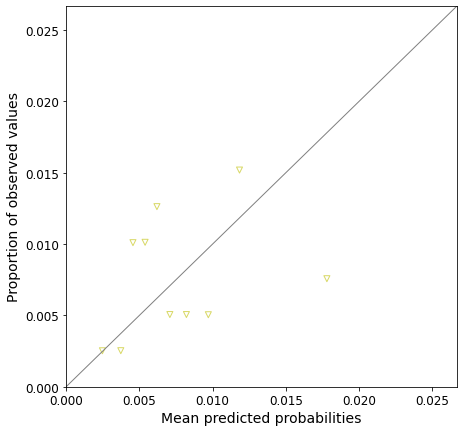

In [54]:
#data prep
data, data_uti_no_abs_prevl_enc = cox_data_prep(data_uti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_prevl', data_uti_no_abs_prevl)

try:
    #build cox model 
    cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test = cox_model_build('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_prevl.csv', data_uti_no_abs_prevl_enc, data_uti_no_abs_prevl, 'sum_betas_cph_uti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_prevl, 'event_uti_admitted', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, 'event_uti_admitted', data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_prevl_train.jpg', 'calibration_cph_uti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_prevl, 'uti', 'no_abs_prevl', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent uti with antibiotics

<lifelines.CoxPHFitter: fitted with 1337 total observations, 1329 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1337
number of events observed = 8
   partial log-likelihood = -41.71
         time fit was run = 2022-11-17 16:21:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.83       0.44       1.00            -2.80             1.14                 0.06                 3.11
CCI_cat[T.medium]               -0.14       0.87       1.07            -2.24             1.95                 0.11                 7.02
CCI_cat[T.high]                 -0.48       0.62       1.28            -2.99             2.03                 0.05                 7.58
CCI_cat[T.very_high]           -19.08       0.00    7306.47        -14339.49         14301.34                 0.00                  inf
age_cat[T.25_34]                -1.22       0.29       1.32            -3.82             1.37                 0.02                 3.95
age_cat[T.35_44]               -19.38       0.00    8327.68        -16341.34         16302.58                 0.00                  inf
age_cat[T.45_54]                -0.55       0.58       1.31            -3.12             2.02                 0.04                 7.52
age_cat[T.55_64]               -19.24       0.00    7867.10        -15438.46         15399.99                 0.00                  inf
age_cat[T.65_74]                -0.32       0.72       1.11            -2.50             1.85                 0.08                 6.39
age_cat[T.75_more]              -0.37       0.69       1.11            -2.54             1.80                 0.08                 6.06
antibacterial_brit              -0.04       0.96       0.29            -0.60             0.51                 0.55                 1.67
bmi_cat[T.obese]                -0.43       0.65       1.32            -3.02             2.16                 0.05                 8.71
bmi_cat[T.overweight]           -0.30       0.74       1.63            -3.51             2.90                 0.03                18.20
bmi_cat[T.underweight]         -18.81       0.00   14688.02        -28806.81         28769.19                 0.00                  inf
bmi_cat[T.unknown]              -0.07       0.93       1.50            -3.00             2.86                 0.05                17.50
ethnicity[T.unknown]            -0.97       0.38       1.06            -3.05             1.11                 0.05                 3.03
ethnicity[T.white]              -1.53       0.22       0.91            -3.31             0.26                 0.04                 1.30
flu_vaccine[T.yes]             -18.51       0.00    9034.40        -17725.61         17688.59                 0.00                  inf
imd[T.medium]                    0.76       2.15       1.33            -1.83             3.36                 0.16                28.87
imd[T.unaffluent]               -0.59       0.55       1.54            -3.62             2.43                 0.03                11.38
imd[T.unknown]                 -17.61       0.00   11691.00        -22931.56         22896.33                 0.00                  inf
imd[T.very_affluent]             0.53       1.70       1.28            -1.97             3.04                 0.14                20.89
imd[T.very_unaffluent]           0.86       2.35       1.35            -1.79             3.50                 0.17                33.08
region[T.east_midlands]         -0.05       0.95   15586.79        -30549.59         30549.49                 0.00                  inf
region[T.london]                19.35   2.54e+08   10335.12        -20237.11 

13010


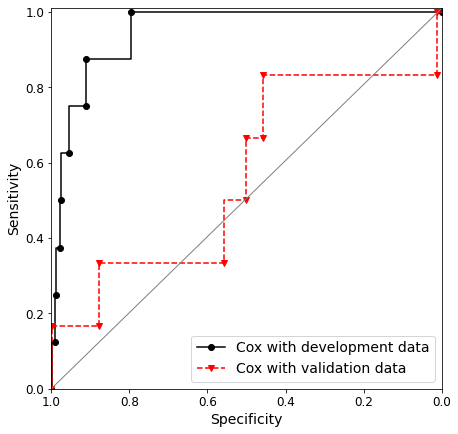

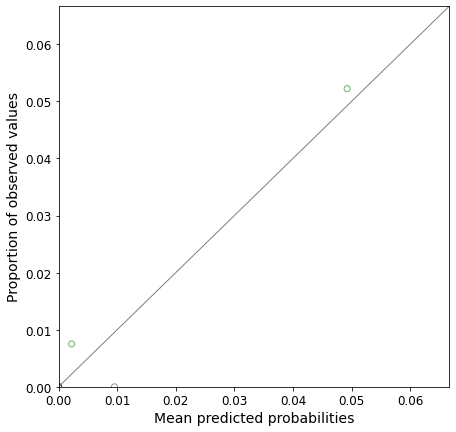

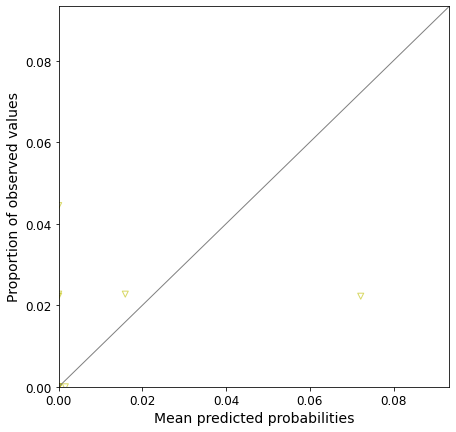

In [55]:
#data prep
data, data_uti_abs_prevl_enc = cox_data_prep(data_uti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_prevl', data_uti_abs_prevl)

try:
    #build cox model 
    cph_uti_abs_prevl, data_uti_abs_prevl_train, data_uti_abs_prevl_test = cox_model_build('uti', 'abs_prevl', data_uti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_prevl.csv', data_uti_abs_prevl_enc, data_uti_abs_prevl, 'sum_betas_cph_uti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_prevl, 'event_uti_admitted', data_uti_abs_prevl_train, data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_prevl, data_uti_abs_prevl_train, 'event_uti_admitted', data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_prevl_train.jpg', 'calibration_cph_uti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_prevl, 'uti', 'abs_prevl', data_uti_abs_prevl_train, data_uti_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident uti

In [56]:
#data prep
data, data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'incdt', data_uti_incdt_enc)
make_summary_table_hosped('uti', 'incdt', data_uti_incdt)

try:
    cph_uti_incdt, data_uti_incdt_train, data_uti_incdt_test = cox_model_abs_build('uti', 'incdt', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt, 'uti', 'incdt', data_uti_incdt_train, data_uti_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119468 total observations, 118588 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 119468
number of events observed = 880
   partial log-likelihood = -10259.72
         time fit was run = 2022-11-17 16:21:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.10             0.05             0.46                 1.05                 1.58
CCI_cat[T.medium]                0.24       1.27       0.11             0.02             0.47                 1.02                 1.59
CCI_cat[T.high]                  0.34       1.41       0.13             0.09             0.60                 1.09                 1.83
CCI_cat[T.very_high]             0.25       1.28       0.12             0.01             0.48                 1.01                 1.62
age_cat[T.25_34]                -0.01       0.99       0.13            -0.27             0.24                 0.77                 1.27
age_cat[T.35_44]                 0.04       1.04       0.13            -0.21             0.29                 0.81                 1.34
age_cat[T.45_54]                 0.00       1.00       0.13            -0.25             0.26                 0.78                 1.29
age_cat[T.55_64]                 0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
age_cat[T.65_74]                 0.07       1.08       0.13            -0.18             0.32                 0.84                 1.38
age_cat[T.75_more]               0.19       1.21       0.12            -0.06             0.43                 0.94                 1.54
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.16       1.17       0.14            -0.11             0.42                 0.89                 1.53
bmi_cat[T.overweight]            0.16       1.17       0.16            -0.16             0.48                 0.85                 1.61
bmi_cat[T.underweight]          -0.07       0.94       0.24            -0.55             0.41                 0.58                 1.51
bmi_cat[T.unknown]               0.25       1.28       0.14            -0.03             0.53                 0.97                 1.70
ethnicity[T.unknown]             0.37       1.45       0.12             0.13             0.60                 1.14                 1.83
ethnicity[T.white]               0.33       1.39       0.11             0.11             0.54                 1.12                 1.72
flu_vaccine[T.yes]              -0.15       0.86       0.12            -0.38             0.09                 0.68                 1.09
imd[T.medium]                   -0.07       0.93       0.11            -0.29             0.14                 0.75                 1.15
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.14                 0.75                 1.16
imd[T.unknown]                   0.13       1.14       0.16            -0.18             0.44                 0.83                 1.55
imd[T.very_affluent]            -0.03       0.97       0.11            -0.24             0.18                 0.79                 1.20
imd[T.very_unaffluent]          -0.03       0.97       0.11            -0.24             0.18                 0.78                 1.20
region[T.east_midlands]          0.14       1.14       0.15            -0.16             0.44                 0.85                 1.55
region[T.london]                 0.24       1.28       0.13       

13036


### 5-6- hospital admission related to prevalent uti

In [57]:
#data prep
data, data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'prevl', data_uti_prevl_enc)
make_summary_table_hosped('uti', 'prevl', data_uti_prevl)

try:
    cph_uti_prevl, data_uti_prevl_train, data_uti_prevl_test = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl, 'uti', 'prevl', data_uti_prevl_train, data_uti_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13200 total observations, 13100 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13200
number of events observed = 100
   partial log-likelihood = -934.17
         time fit was run = 2022-11-17 16:21:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.30            -0.67             0.50                 0.51                 1.65
CCI_cat[T.medium]                0.19       1.21       0.32            -0.42             0.81                 0.65                 2.25
CCI_cat[T.high]                 -0.03       0.97       0.39            -0.81             0.74                 0.45                 2.10
CCI_cat[T.very_high]             0.22       1.25       0.33            -0.42             0.87                 0.66                 2.39
age_cat[T.25_34]                -0.13       0.88       0.38            -0.87             0.62                 0.42                 1.85
age_cat[T.35_44]                -0.12       0.88       0.38            -0.87             0.62                 0.42                 1.86
age_cat[T.45_54]                -0.09       0.91       0.38            -0.83             0.65                 0.43                 1.92
age_cat[T.55_64]                 0.02       1.02       0.37            -0.70             0.73                 0.50                 2.08
age_cat[T.65_74]                -0.13       0.88       0.38            -0.87             0.61                 0.42                 1.85
age_cat[T.75_more]               0.23       1.26       0.35            -0.46             0.92                 0.63                 2.50
antibacterial_brit               0.04       1.05       0.07            -0.09             0.18                 0.91                 1.20
bmi_cat[T.obese]                -0.82       0.44       0.29            -1.38            -0.25                 0.25                 0.78
bmi_cat[T.overweight]           -0.81       0.44       0.40            -1.60            -0.02                 0.20                 0.98
bmi_cat[T.underweight]          -1.94       0.14       1.03            -3.96             0.09                 0.02                 1.09
bmi_cat[T.unknown]              -0.69       0.50       0.32            -1.32            -0.07                 0.27                 0.93
ethnicity[T.unknown]            -0.31       0.73       0.33            -0.95             0.33                 0.39                 1.39
ethnicity[T.white]              -0.08       0.92       0.27            -0.62             0.46                 0.54                 1.58
flu_vaccine[T.yes]               0.02       1.02       0.33            -0.64             0.67                 0.53                 1.96
imd[T.medium]                    0.53       1.71       0.31            -0.07             1.14                 0.93                 3.12
imd[T.unaffluent]                0.25       1.29       0.33            -0.39             0.90                 0.68                 2.45
imd[T.unknown]                  -0.36       0.70       0.63            -1.58             0.87                 0.20                 2.39
imd[T.very_affluent]            -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.66
imd[T.very_unaffluent]           0.03       1.03       0.34            -0.64             0.71                 0.53                 2.02
region[T.east_midlands]          0.01       1.01       0.38            -0.74             0.75                 0.48                 2.12
region[T.london]                -0.47       0.62       0.36            

13053


### 5-7- hospital admission related to incident uti with prescribed antibiotics categories

In [58]:
#data prep
data, data_uti_incdt_abs_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_abs, data_uti_incdt_abs_train, data_uti_incdt_abs_test = cox_model_ab_type_build('uti', 'incdt_ab_type', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_abs, 'uti', 'incdt_abs', data_uti_incdt_abs_train, data_uti_incdt_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119468 total observations, 118588 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 119468
number of events observed = 880
   partial log-likelihood = -10257.44
         time fit was run = 2022-11-17 16:21:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.10             0.05             0.46                 1.05                 1.58
CCI_cat[T.medium]                0.24       1.27       0.11             0.02             0.47                 1.02                 1.60
CCI_cat[T.high]                  0.34       1.41       0.13             0.09             0.60                 1.09                 1.83
CCI_cat[T.very_high]             0.25       1.28       0.12             0.01             0.48                 1.01                 1.62
ab_type_cat[T.Doxycycline]       1.78       5.90       0.87             0.08             3.47                 1.08                32.23
ab_type_cat[T.no]                0.94       2.56       0.71            -0.45             2.33                 0.64                10.25
ab_type_cat[T.other]             0.90       2.47       0.72            -0.50             2.31                 0.61                10.06
age_cat[T.25_34]                -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.27
age_cat[T.35_44]                 0.04       1.04       0.13            -0.21             0.29                 0.81                 1.34
age_cat[T.45_54]                -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.55_64]                 0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
age_cat[T.65_74]                 0.07       1.07       0.13            -0.18             0.32                 0.84                 1.38
age_cat[T.75_more]               0.19       1.20       0.12            -0.06             0.43                 0.94                 1.54
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.16       1.17       0.14            -0.11             0.42                 0.90                 1.53
bmi_cat[T.overweight]            0.16       1.17       0.16            -0.16             0.48                 0.85                 1.61
bmi_cat[T.underweight]          -0.07       0.94       0.24            -0.55             0.41                 0.58                 1.51
bmi_cat[T.unknown]               0.25       1.28       0.14            -0.03             0.53                 0.97                 1.70
ethnicity[T.unknown]             0.37       1.45       0.12             0.13             0.60                 1.14                 1.83
ethnicity[T.white]               0.33       1.39       0.11             0.11             0.54                 1.12                 1.72
flu_vaccine[T.yes]              -0.14       0.87       0.12            -0.38             0.09                 0.68                 1.09
imd[T.medium]                   -0.08       0.93       0.11            -0.29             0.14                 0.75                 1.15
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.14                 0.75                 1.15
imd[T.unknown]                   0.13       1.14       0.16            -0.18             0.44                 0.83                 1.55
imd[T.very_affluent]            -0.03       0.97       0.11       

13602


### 5-8- hospital admission related to prevalent uti with prescribed antibiotics categories

In [59]:
#data prep
data, data_uti_prevl_abs_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_abs, data_uti_prevl_abs_train, data_uti_prevl_abs_test = cox_model_ab_type_build('uti', 'prevl_ab_type', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_abs, 'uti', 'prevl_abs', data_uti_prevl_abs_train, data_uti_prevl_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13200 total observations, 13100 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13200
number of events observed = 100
   partial log-likelihood = -931.15
         time fit was run = 2022-11-17 16:22:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.30            -0.67             0.50                 0.51                 1.65
CCI_cat[T.medium]                0.20       1.22       0.32            -0.42             0.82                 0.66                 2.27
CCI_cat[T.high]                 -0.06       0.94       0.40            -0.83             0.72                 0.43                 2.05
CCI_cat[T.very_high]             0.24       1.27       0.33            -0.41             0.89                 0.67                 2.42
ab_type_cat[T.Doxycycline]      16.52   1.50e+07    1977.49         -3859.28          3892.33                 0.00                  inf
ab_type_cat[T.no]               14.54   2.06e+06    1977.49         -3861.26          3890.34                 0.00                  inf
ab_type_cat[T.other]            14.24   1.53e+06    1977.49         -3861.56          3890.04                 0.00                  inf
age_cat[T.25_34]                -0.14       0.87       0.38            -0.89             0.61                 0.41                 1.83
age_cat[T.35_44]                -0.13       0.88       0.38            -0.87             0.61                 0.42                 1.85
age_cat[T.45_54]                -0.08       0.92       0.38            -0.82             0.66                 0.44                 1.94
age_cat[T.55_64]                 0.01       1.01       0.37            -0.70             0.73                 0.50                 2.08
age_cat[T.65_74]                -0.14       0.87       0.38            -0.89             0.60                 0.41                 1.82
age_cat[T.75_more]               0.22       1.25       0.35            -0.46             0.91                 0.63                 2.49
antibacterial_brit               0.04       1.04       0.07            -0.10             0.18                 0.91                 1.19
bmi_cat[T.obese]                -0.81       0.44       0.29            -1.38            -0.25                 0.25                 0.78
bmi_cat[T.overweight]           -0.78       0.46       0.40            -1.58             0.01                 0.21                 1.01
bmi_cat[T.underweight]          -1.92       0.15       1.03            -3.94             0.10                 0.02                 1.10
bmi_cat[T.unknown]              -0.69       0.50       0.32            -1.31            -0.06                 0.27                 0.94
ethnicity[T.unknown]            -0.32       0.73       0.33            -0.96             0.32                 0.38                 1.38
ethnicity[T.white]              -0.10       0.90       0.27            -0.64             0.44                 0.53                 1.55
flu_vaccine[T.yes]               0.01       1.01       0.33            -0.64             0.66                 0.53                 1.94
imd[T.medium]                    0.53       1.70       0.31            -0.08             1.13                 0.93                 3.10
imd[T.unaffluent]                0.27       1.31       0.33            -0.37             0.91                 0.69                 2.48
imd[T.unknown]                  -0.37       0.69       0.63            -1.60             0.86                 0.20                 2.37
imd[T.very_affluent]            -0.21       0.81       0.36            

13653


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_uti_incdt_males_enc = cox_data_prep(data_uti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_males, data_uti_incdt_males_train, data_uti_incdt_males_test = cox_model_strat_sex_build('uti', 'incdt_males', data_uti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_males, 'uti', 'incdt_males', data_uti_incdt_males_train, data_uti_incdt_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58559 total observations, 58138 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 58559
number of events observed = 421
   partial log-likelihood = -4601.48
         time fit was run = 2022-11-17 16:22:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.17       0.14            -0.13             0.44                 0.88                 1.55
CCI_cat[T.medium]                0.08       1.09       0.16            -0.24             0.41                 0.79                 1.50
CCI_cat[T.high]                  0.30       1.35       0.19            -0.06             0.66                 0.94                 1.94
CCI_cat[T.very_high]             0.13       1.14       0.17            -0.21             0.46                 0.81                 1.58
age_cat[T.25_34]                -0.33       0.72       0.18            -0.69             0.03                 0.50                 1.03
age_cat[T.35_44]                -0.32       0.73       0.18            -0.68             0.04                 0.51                 1.04
age_cat[T.45_54]                -0.21       0.81       0.18            -0.56             0.14                 0.57                 1.15
age_cat[T.55_64]                 0.01       1.01       0.17            -0.32             0.34                 0.73                 1.41
age_cat[T.65_74]                -0.21       0.81       0.18            -0.56             0.14                 0.57                 1.15
age_cat[T.75_more]              -0.09       0.92       0.17            -0.43             0.25                 0.65                 1.29
antibacterial_brit              -0.00       1.00       0.03            -0.07             0.06                 0.93                 1.07
bmi_cat[T.obese]                 0.21       1.23       0.20            -0.19             0.61                 0.82                 1.84
bmi_cat[T.overweight]            0.43       1.53       0.23            -0.03             0.88                 0.97                 2.42
bmi_cat[T.underweight]           0.41       1.50       0.32            -0.21             1.03                 0.81                 2.79
bmi_cat[T.unknown]               0.30       1.34       0.21            -0.12             0.72                 0.88                 2.05
ethnicity[T.unknown]             0.33       1.39       0.17            -0.01             0.67                 0.99                 1.96
ethnicity[T.white]               0.32       1.38       0.16             0.01             0.63                 1.01                 1.88
flu_vaccine[T.yes]              -0.39       0.68       0.19            -0.76            -0.02                 0.47                 0.98
imd[T.medium]                   -0.11       0.90       0.16            -0.43             0.22                 0.65                 1.24
imd[T.unaffluent]                0.07       1.07       0.16            -0.24             0.38                 0.79                 1.46
imd[T.unknown]                   0.24       1.28       0.23            -0.20             0.69                 0.82                 1.99
imd[T.very_affluent]            -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.22
imd[T.very_unaffluent]           0.20       1.22       0.15            -0.10             0.50                 0.90                 1.64
region[T.east_midlands]          0.00       1.00       0.23            -0.44             0.45                 0.64                 1.57
region[T.london]                 0.16       1.17       0.19           

12756


#### 5-9-2- incident females

In [61]:
#data prep
data, data_uti_incdt_females_enc = cox_data_prep(data_uti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_females, data_uti_incdt_females_train, data_uti_incdt_females_test = cox_model_strat_sex_build('uti', 'incdt_females', data_uti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_females, 'uti', 'incdt_females', data_uti_incdt_females_train, data_uti_incdt_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60909 total observations, 60466 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 60909
number of events observed = 443
   partial log-likelihood = -4858.12
         time fit was run = 2022-11-17 16:22:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.14            -0.27             0.27                 0.76                 1.32
CCI_cat[T.medium]                0.11       1.12       0.15            -0.19             0.41                 0.83                 1.51
CCI_cat[T.high]                  0.21       1.23       0.18            -0.14             0.55                 0.87                 1.74
CCI_cat[T.very_high]            -0.01       0.99       0.17            -0.34             0.31                 0.71                 1.37
age_cat[T.25_34]                 0.14       1.16       0.18            -0.21             0.50                 0.81                 1.65
age_cat[T.35_44]                 0.14       1.15       0.18            -0.22             0.50                 0.80                 1.64
age_cat[T.45_54]                 0.15       1.16       0.18            -0.21             0.51                 0.81                 1.67
age_cat[T.55_64]                -0.10       0.91       0.20            -0.48             0.29                 0.62                 1.34
age_cat[T.65_74]                 0.27       1.31       0.18            -0.08             0.62                 0.93                 1.86
age_cat[T.75_more]               0.21       1.24       0.18            -0.14             0.57                 0.87                 1.77
antibacterial_brit               0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                 0.22       1.24       0.20            -0.17             0.60                 0.84                 1.83
bmi_cat[T.overweight]            0.28       1.32       0.23            -0.18             0.73                 0.84                 2.07
bmi_cat[T.underweight]           0.16       1.18       0.33            -0.48             0.80                 0.62                 2.23
bmi_cat[T.unknown]               0.25       1.28       0.21            -0.16             0.66                 0.85                 1.93
ethnicity[T.unknown]             0.07       1.07       0.16            -0.24             0.38                 0.79                 1.46
ethnicity[T.white]               0.06       1.06       0.14            -0.22             0.34                 0.80                 1.40
flu_vaccine[T.yes]              -0.21       0.81       0.17            -0.56             0.13                 0.57                 1.13
imd[T.medium]                    0.12       1.13       0.15            -0.17             0.41                 0.84                 1.51
imd[T.unaffluent]               -0.19       0.82       0.16            -0.51             0.12                 0.60                 1.13
imd[T.unknown]                  -0.01       0.99       0.23            -0.47             0.45                 0.63                 1.57
imd[T.very_affluent]            -0.09       0.92       0.15            -0.39             0.22                 0.68                 1.24
imd[T.very_unaffluent]          -0.09       0.92       0.15            -0.39             0.21                 0.68                 1.24
region[T.east_midlands]         -0.03       0.97       0.22            -0.46             0.40                 0.63                 1.50
region[T.london]                 0.35       1.42       0.18           

12764


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_uti_prevl_males_enc = cox_data_prep(data_uti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_males, data_uti_prevl_males_train, data_uti_prevl_males_test = cox_model_strat_sex_build('uti', 'prevl_males', data_uti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_uti_prevl_males, 'uti', 'prevl_males', data_uti_prevl_males_train, data_uti_prevl_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6395 total observations, 6341 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 6395
number of events observed = 54
   partial log-likelihood = -459.74
         time fit was run = 2022-11-17 16:22:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.66       0.52       0.37            -1.39             0.08                 0.25                 1.08
CCI_cat[T.medium]               -0.13       0.88       0.37            -0.87             0.60                 0.42                 1.82
CCI_cat[T.high]                 -1.10       0.33       0.63            -2.34             0.15                 0.10                 1.16
CCI_cat[T.very_high]            -0.46       0.63       0.44            -1.32             0.40                 0.27                 1.49
age_cat[T.25_34]                 0.54       1.71       0.52            -0.48             1.55                 0.62                 4.72
age_cat[T.35_44]                 0.15       1.17       0.56            -0.94             1.25                 0.39                 3.48
age_cat[T.45_54]                -0.14       0.87       0.61            -1.33             1.05                 0.26                 2.85
age_cat[T.55_64]                 0.24       1.27       0.54            -0.82             1.31                 0.44                 3.69
age_cat[T.65_74]                 0.28       1.32       0.54            -0.78             1.34                 0.46                 3.83
age_cat[T.75_more]               0.47       1.61       0.52            -0.54             1.49                 0.58                 4.44
antibacterial_brit               0.11       1.11       0.09            -0.07             0.29                 0.93                 1.34
bmi_cat[T.obese]                -0.56       0.57       0.43            -1.39             0.28                 0.25                 1.32
bmi_cat[T.overweight]           -0.55       0.58       0.56            -1.64             0.55                 0.19                 1.73
bmi_cat[T.underweight]         -16.46       0.00    2203.27         -4334.80          4301.87                 0.00                  inf
bmi_cat[T.unknown]              -0.52       0.59       0.46            -1.43             0.39                 0.24                 1.48
ethnicity[T.unknown]            -0.23       0.80       0.42            -1.05             0.60                 0.35                 1.83
ethnicity[T.white]              -0.22       0.80       0.37            -0.94             0.49                 0.39                 1.64
flu_vaccine[T.yes]               0.29       1.33       0.41            -0.51             1.08                 0.60                 2.95
imd[T.medium]                   -0.01       0.99       0.43            -0.85             0.83                 0.43                 2.29
imd[T.unaffluent]                0.17       1.18       0.42            -0.65             0.99                 0.52                 2.69
imd[T.unknown]                   0.15       1.16       0.65            -1.13             1.43                 0.32                 4.19
imd[T.very_affluent]            -0.46       0.63       0.49            -1.41             0.49                 0.24                 1.64
imd[T.very_unaffluent]          -0.04       0.97       0.44            -0.89             0.82                 0.41                 2.28
region[T.east_midlands]          0.09       1.10       0.47            -0.84             1.02                 0.43                 2.77
region[T.london]                -0.54       0.58       0.46            -1.4

12783


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_uti_prevl_females_enc = cox_data_prep(data_uti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

    #cox model
    cph_uti_prevl_females, data_uti_prevl_females_train, data_uti_prevl_females_test = cox_model_strat_sex_build('uti', 'prevl_females', data_uti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_females, 'uti', 'prevl_females', data_uti_prevl_females_train, data_uti_prevl_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6805 total observations, 6752 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 6805
number of events observed = 53
   partial log-likelihood = -445.93
         time fit was run = 2022-11-17 16:22:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.45            -0.63             1.13                 0.53                 3.11
CCI_cat[T.medium]                0.44       1.56       0.48            -0.49             1.38                 0.61                 3.97
CCI_cat[T.high]                  0.38       1.47       0.56            -0.71             1.48                 0.49                 4.38
CCI_cat[T.very_high]             0.66       1.93       0.49            -0.29             1.61                 0.75                 5.00
age_cat[T.25_34]                -0.55       0.58       0.73            -1.99             0.88                 0.14                 2.41
age_cat[T.35_44]                 0.33       1.40       0.59            -0.82             1.49                 0.44                 4.43
age_cat[T.45_54]                 0.42       1.53       0.59            -0.73             1.58                 0.48                 4.84
age_cat[T.55_64]                 0.87       2.39       0.54            -0.18             1.92                 0.84                 6.84
age_cat[T.65_74]                 0.49       1.63       0.57            -0.63             1.61                 0.53                 4.99
age_cat[T.75_more]               0.82       2.27       0.54            -0.24             1.88                 0.79                 6.55
antibacterial_brit              -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.20
bmi_cat[T.obese]                -0.86       0.43       0.41            -1.66            -0.05                 0.19                 0.95
bmi_cat[T.overweight]           -1.04       0.35       0.62            -2.25             0.17                 0.11                 1.18
bmi_cat[T.underweight]          -1.41       0.24       1.06            -3.49             0.68                 0.03                 1.97
bmi_cat[T.unknown]              -0.68       0.51       0.44            -1.55             0.18                 0.21                 1.20
ethnicity[T.unknown]            -0.20       0.81       0.46            -1.10             0.69                 0.33                 2.00
ethnicity[T.white]              -0.05       0.95       0.40            -0.82             0.73                 0.44                 2.07
flu_vaccine[T.yes]              -0.21       0.81       0.52            -1.23             0.81                 0.29                 2.26
imd[T.medium]                    0.97       2.64       0.48             0.02             1.92                 1.02                 6.84
imd[T.unaffluent]                1.04       2.82       0.48             0.11             1.97                 1.11                 7.18
imd[T.unknown]                  -0.53       0.59       1.08            -2.65             1.59                 0.07                 4.91
imd[T.very_affluent]             0.24       1.27       0.54            -0.82             1.30                 0.44                 3.68
imd[T.very_unaffluent]          -0.04       0.96       0.58            -1.18             1.09                 0.31                 2.98
region[T.east_midlands]         -0.22       0.81       0.51            -1.21             0.77                 0.30                 2.17
region[T.london]                -0.69       0.50       0.47            -1.6

12770


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_uti_incdt_15_24_enc = cox_data_prep(data_uti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_15_24, data_uti_incdt_15_24_train, data_uti_incdt_15_24_test = cox_model_strat_age_build('uti', 'incdt_15_24', data_uti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_15_24, 'uti', 'incdt_15_24', data_uti_incdt_15_24_train, data_uti_incdt_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17069 total observations, 16942 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17069
number of events observed = 127
   partial log-likelihood = -1215.61
         time fit was run = 2022-11-17 16:22:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.77       2.17       0.32             0.14             1.41                 1.15                 4.08
CCI_cat[T.medium]                0.47       1.59       0.37            -0.26             1.19                 0.77                 3.29
CCI_cat[T.high]                  1.08       2.95       0.37             0.36             1.81                 1.43                 6.09
CCI_cat[T.very_high]             1.04       2.84       0.34             0.37             1.72                 1.45                 5.56
antibacterial_brit              -0.07       0.93       0.06            -0.19             0.06                 0.82                 1.06
bmi_cat[T.obese]                -0.17       0.84       0.31            -0.79             0.44                 0.45                 1.56
bmi_cat[T.overweight]            0.11       1.12       0.37            -0.61             0.84                 0.54                 2.31
bmi_cat[T.underweight]          -0.42       0.66       0.65            -1.69             0.85                 0.18                 2.33
bmi_cat[T.unknown]              -0.31       0.73       0.35            -0.99             0.36                 0.37                 1.44
ethnicity[T.unknown]             0.57       1.77       0.31            -0.04             1.18                 0.96                 3.26
ethnicity[T.white]               0.26       1.29       0.29            -0.32             0.83                 0.73                 2.30
flu_vaccine[T.yes]              -0.67       0.51       0.39            -1.43             0.10                 0.24                 1.10
imd[T.medium]                   -0.10       0.91       0.30            -0.68             0.49                 0.50                 1.63
imd[T.unaffluent]               -0.07       0.93       0.30            -0.65             0.51                 0.52                 1.67
imd[T.unknown]                   0.68       1.97       0.35            -0.00             1.36                 1.00                 3.89
imd[T.very_affluent]            -0.12       0.88       0.30            -0.72             0.47                 0.49                 1.60
imd[T.very_unaffluent]           0.06       1.06       0.29            -0.51             0.62                 0.60                 1.87
region[T.east_midlands]         -0.57       0.57       0.44            -1.43             0.29                 0.24                 1.33
region[T.london]                 0.10       1.11       0.32            -0.52             0.72                 0.60                 2.05
region[T.north_east]            -0.38       0.68       0.41            -1.18             0.42                 0.31                 1.53
region[T.north_west]             0.05       1.05       0.37            -0.67             0.77                 0.51                 2.16
region[T.south_east]            -0.08       0.93       0.37            -0.81             0.65                 0.45                 1.92
region[T.south_west]            -0.30       0.74       0.40            -1.08             0.48                 0.34                 1.62
region[T.west_midlands]         -0.44       0.65       0.41            -1.24             0.36                 0.29                 1.44
region[T.yorkshire]             -0.13       0.87       0.38           

11404


In [65]:
#data prep
data, data_uti_incdt_25_34_enc = cox_data_prep(data_uti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_25_34, data_uti_incdt_25_34_train, data_uti_incdt_25_34_test = cox_model_strat_age_build('uti', 'incdt_25_34', data_uti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_25_34, 'uti', 'incdt_25_34', data_uti_incdt_25_34_train, data_uti_incdt_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17323 total observations, 17200 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17323
number of events observed = 123
   partial log-likelihood = -1179.11
         time fit was run = 2022-11-17 16:22:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.58       1.78       0.30            -0.02             1.18                 0.98                 3.24
CCI_cat[T.medium]                0.69       1.99       0.32             0.05             1.32                 1.05                 3.75
CCI_cat[T.high]                  0.77       2.15       0.37             0.05             1.48                 1.05                 4.41
CCI_cat[T.very_high]             0.24       1.28       0.37            -0.48             0.96                 0.62                 2.61
antibacterial_brit               0.07       1.08       0.06            -0.05             0.20                 0.95                 1.22
bmi_cat[T.obese]                -0.07       0.93       0.33            -0.71             0.57                 0.49                 1.77
bmi_cat[T.overweight]           -0.20       0.82       0.41            -1.00             0.61                 0.37                 1.83
bmi_cat[T.underweight]          -0.83       0.44       0.77            -2.34             0.68                 0.10                 1.97
bmi_cat[T.unknown]              -0.08       0.92       0.35            -0.77             0.61                 0.46                 1.84
ethnicity[T.unknown]             0.16       1.18       0.30            -0.42             0.75                 0.65                 2.12
ethnicity[T.white]               0.15       1.16       0.27            -0.38             0.68                 0.69                 1.97
flu_vaccine[T.yes]              -0.80       0.45       0.42            -1.62             0.02                 0.20                 1.02
imd[T.medium]                   -0.35       0.70       0.27            -0.89             0.19                 0.41                 1.20
imd[T.unaffluent]               -0.61       0.54       0.30            -1.19            -0.03                 0.31                 0.97
imd[T.unknown]                  -0.79       0.45       0.53            -1.83             0.25                 0.16                 1.29
imd[T.very_affluent]            -0.35       0.71       0.27            -0.89             0.19                 0.41                 1.21
imd[T.very_unaffluent]          -0.36       0.70       0.27            -0.90             0.18                 0.41                 1.19
region[T.east_midlands]         -0.15       0.86       0.39            -0.91             0.60                 0.40                 1.83
region[T.london]                 0.13       1.14       0.32            -0.49             0.76                 0.61                 2.13
region[T.north_east]            -0.42       0.66       0.41            -1.23             0.39                 0.29                 1.48
region[T.north_west]            -0.03       0.97       0.39            -0.78             0.73                 0.46                 2.07
region[T.south_east]            -0.41       0.66       0.41            -1.23             0.40                 0.29                 1.49
region[T.south_west]            -0.92       0.40       0.49            -1.88             0.03                 0.15                 1.03
region[T.west_midlands]         -0.01       0.99       0.37            -0.74             0.72                 0.48                 2.06
region[T.yorkshire]             -0.58       0.56       0.44           

11409


In [66]:
#data prep
data, data_uti_incdt_35_44_enc = cox_data_prep(data_uti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_35_44, data_uti_incdt_35_44_train, data_uti_incdt_35_44_test = cox_model_strat_age_build('uti', 'incdt_35_44', data_uti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_35_44, 'uti', 'incdt_35_44', data_uti_incdt_35_44_train, data_uti_incdt_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17165 total observations, 17034 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17165
number of events observed = 131
   partial log-likelihood = -1261.84
         time fit was run = 2022-11-17 16:22:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.43       1.54       0.27            -0.09             0.96                 0.92                 2.60
CCI_cat[T.medium]                0.19       1.21       0.30            -0.40             0.79                 0.67                 2.21
CCI_cat[T.high]                  0.12       1.12       0.37            -0.61             0.84                 0.54                 2.32
CCI_cat[T.very_high]             0.21       1.23       0.32            -0.42             0.84                 0.66                 2.31
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.88                 1.12
bmi_cat[T.obese]                -0.23       0.79       0.30            -0.83             0.36                 0.44                 1.43
bmi_cat[T.overweight]           -0.27       0.76       0.39            -1.03             0.48                 0.36                 1.62
bmi_cat[T.underweight]          -0.57       0.56       0.64            -1.83             0.69                 0.16                 1.98
bmi_cat[T.unknown]              -0.34       0.71       0.33            -0.99             0.31                 0.37                 1.36
ethnicity[T.unknown]             0.60       1.82       0.32            -0.03             1.23                 0.97                 3.43
ethnicity[T.white]               0.45       1.57       0.30            -0.14             1.04                 0.87                 2.82
flu_vaccine[T.yes]              -0.16       0.85       0.32            -0.78             0.46                 0.46                 1.58
imd[T.medium]                    0.44       1.55       0.29            -0.13             1.00                 0.88                 2.72
imd[T.unaffluent]                0.25       1.29       0.30            -0.33             0.83                 0.72                 2.29
imd[T.unknown]                   0.53       1.70       0.40            -0.26             1.32                 0.77                 3.74
imd[T.very_affluent]            -0.03       0.97       0.32            -0.65             0.59                 0.52                 1.80
imd[T.very_unaffluent]           0.18       1.19       0.30            -0.41             0.76                 0.66                 2.15
region[T.east_midlands]          0.89       2.44       0.40             0.11             1.67                 1.12                 5.33
region[T.london]                 0.57       1.77       0.38            -0.17             1.31                 0.84                 3.71
region[T.north_east]             0.31       1.36       0.44            -0.56             1.17                 0.57                 3.22
region[T.north_west]             0.03       1.03       0.47            -0.90             0.95                 0.41                 2.59
region[T.south_east]             0.21       1.24       0.45            -0.67             1.09                 0.51                 2.99
region[T.south_west]             0.37       1.45       0.43            -0.48             1.22                 0.62                 3.40
region[T.west_midlands]          0.35       1.42       0.44            -0.51             1.22                 0.60                 3.37
region[T.yorkshire]              0.43       1.54       0.43           

11383


In [67]:
#data prep
data, data_uti_incdt_45_54_enc = cox_data_prep(data_uti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_45_54, data_uti_incdt_45_54_train, data_uti_incdt_45_54_test = cox_model_strat_age_build('uti', 'incdt_45_54', data_uti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_45_54, 'uti', 'incdt_45_54', data_uti_incdt_45_54_train, data_uti_incdt_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17085 total observations, 16962 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17085
number of events observed = 123
   partial log-likelihood = -1183.16
         time fit was run = 2022-11-17 16:22:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.27            -0.62             0.45                 0.54                 1.58
CCI_cat[T.medium]                0.23       1.26       0.28            -0.33             0.79                 0.72                 2.20
CCI_cat[T.high]                  0.33       1.38       0.33            -0.31             0.97                 0.73                 2.63
CCI_cat[T.very_high]            -0.11       0.89       0.32            -0.74             0.52                 0.47                 1.68
antibacterial_brit              -0.16       0.86       0.07            -0.29            -0.02                 0.75                 0.98
bmi_cat[T.obese]                 0.43       1.53       0.43            -0.41             1.27                 0.66                 3.55
bmi_cat[T.overweight]            0.96       2.61       0.46             0.06             1.86                 1.06                 6.45
bmi_cat[T.underweight]           0.73       2.07       0.61            -0.46             1.92                 0.63                 6.81
bmi_cat[T.unknown]               0.42       1.53       0.45            -0.46             1.30                 0.63                 3.68
ethnicity[T.unknown]             0.02       1.02       0.29            -0.56             0.59                 0.57                 1.81
ethnicity[T.white]              -0.02       0.98       0.26            -0.54             0.50                 0.58                 1.64
flu_vaccine[T.yes]              -0.47       0.62       0.37            -1.19             0.24                 0.30                 1.28
imd[T.medium]                    0.35       1.42       0.30            -0.23             0.94                 0.79                 2.56
imd[T.unaffluent]                0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
imd[T.unknown]                   0.04       1.04       0.50            -0.95             1.03                 0.39                 2.79
imd[T.very_affluent]             0.26       1.30       0.30            -0.34             0.86                 0.71                 2.36
imd[T.very_unaffluent]           0.35       1.41       0.30            -0.24             0.93                 0.79                 2.55
region[T.east_midlands]          0.13       1.14       0.42            -0.69             0.95                 0.50                 2.58
region[T.london]                 0.35       1.42       0.35            -0.34             1.04                 0.71                 2.83
region[T.north_east]             0.15       1.17       0.41            -0.65             0.96                 0.52                 2.61
region[T.north_west]             0.13       1.14       0.42            -0.69             0.95                 0.50                 2.58
region[T.south_east]            -0.16       0.85       0.45            -1.04             0.72                 0.35                 2.06
region[T.south_west]            -0.05       0.95       0.44            -0.91             0.81                 0.40                 2.24
region[T.west_midlands]          0.44       1.56       0.39            -0.32             1.20                 0.73                 3.33
region[T.yorkshire]             -0.27       0.76       0.47           

11391


In [68]:
#data prep
data, data_uti_incdt_55_64_enc = cox_data_prep(data_uti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_55_64, data_uti_incdt_55_64_train, data_uti_incdt_55_64_test = cox_model_strat_age_build('uti', 'incdt_55_64', data_uti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_55_64, 'uti', 'incdt_55_64', data_uti_incdt_55_64_train, data_uti_incdt_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16651 total observations, 16517 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 16651
number of events observed = 134
   partial log-likelihood = -1285.08
         time fit was run = 2022-11-17 16:22:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.26            -0.27             0.73                 0.76                 2.07
CCI_cat[T.medium]               -0.00       1.00       0.30            -0.60             0.59                 0.55                 1.80
CCI_cat[T.high]                  0.41       1.50       0.32            -0.23             1.04                 0.80                 2.84
CCI_cat[T.very_high]             0.23       1.25       0.30            -0.37             0.82                 0.69                 2.27
antibacterial_brit               0.00       1.00       0.06            -0.12             0.12                 0.89                 1.13
bmi_cat[T.obese]                 0.40       1.49       0.37            -0.33             1.13                 0.72                 3.09
bmi_cat[T.overweight]            0.52       1.69       0.43            -0.31             1.36                 0.73                 3.89
bmi_cat[T.underweight]           0.44       1.55       0.57            -0.68             1.55                 0.51                 4.73
bmi_cat[T.unknown]               0.27       1.31       0.40            -0.50             1.05                 0.60                 2.86
ethnicity[T.unknown]             0.15       1.17       0.33            -0.48             0.79                 0.62                 2.21
ethnicity[T.white]               0.46       1.58       0.29            -0.11             1.02                 0.90                 2.77
flu_vaccine[T.yes]              -0.20       0.82       0.32            -0.82             0.42                 0.44                 1.52
imd[T.medium]                   -0.10       0.91       0.27            -0.63             0.44                 0.53                 1.55
imd[T.unaffluent]               -0.19       0.83       0.28            -0.73             0.36                 0.48                 1.43
imd[T.unknown]                  -0.01       0.99       0.42            -0.84             0.82                 0.43                 2.28
imd[T.very_affluent]            -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.66
imd[T.very_unaffluent]          -0.27       0.76       0.29            -0.83             0.28                 0.43                 1.33
region[T.east_midlands]         -0.17       0.84       0.37            -0.90             0.55                 0.41                 1.73
region[T.london]                -0.37       0.69       0.32            -1.00             0.27                 0.37                 1.31
region[T.north_east]             0.13       1.14       0.34            -0.54             0.81                 0.58                 2.24
region[T.north_west]             0.28       1.32       0.33            -0.36             0.92                 0.69                 2.50
region[T.south_east]            -0.35       0.70       0.39            -1.11             0.41                 0.33                 1.50
region[T.south_west]            -0.54       0.58       0.41            -1.35             0.27                 0.26                 1.31
region[T.west_midlands]         -0.06       0.94       0.35            -0.76             0.63                 0.47                 1.89
region[T.yorkshire]             -0.59       0.55       0.41           

11394


In [69]:
#data prep
data, data_uti_incdt_65_74_enc = cox_data_prep(data_uti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_65_74, data_uti_incdt_65_74_train, data_uti_incdt_65_74_test = cox_model_strat_age_build('uti', 'incdt_65_74', data_uti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_65_74, 'uti', 'incdt_65_74', data_uti_incdt_65_74_train, data_uti_incdt_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17289 total observations, 17146 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 17289
number of events observed = 143
   partial log-likelihood = -1382.60
         time fit was run = 2022-11-17 16:22:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.24            -0.53             0.43                 0.59                 1.54
CCI_cat[T.medium]                0.14       1.15       0.26            -0.37             0.66                 0.69                 1.93
CCI_cat[T.high]                  0.19       1.21       0.31            -0.41             0.79                 0.66                 2.21
CCI_cat[T.very_high]            -0.24       0.79       0.30            -0.83             0.36                 0.44                 1.43
antibacterial_brit               0.01       1.01       0.06            -0.11             0.12                 0.90                 1.13
bmi_cat[T.obese]                 0.26       1.30       0.35            -0.43             0.95                 0.65                 2.59
bmi_cat[T.overweight]            0.20       1.22       0.42            -0.63             1.03                 0.53                 2.80
bmi_cat[T.underweight]           0.19       1.21       0.56            -0.90             1.29                 0.41                 3.62
bmi_cat[T.unknown]               0.36       1.43       0.37            -0.36             1.08                 0.69                 2.94
ethnicity[T.unknown]            -0.16       0.85       0.30            -0.74             0.42                 0.48                 1.52
ethnicity[T.white]               0.19       1.21       0.25            -0.30             0.68                 0.74                 1.98
flu_vaccine[T.yes]              -0.18       0.83       0.30            -0.78             0.41                 0.46                 1.50
imd[T.medium]                   -0.29       0.75       0.28            -0.85             0.26                 0.43                 1.30
imd[T.unaffluent]               -0.27       0.77       0.28            -0.82             0.29                 0.44                 1.34
imd[T.unknown]                   0.03       1.03       0.40            -0.75             0.82                 0.47                 2.26
imd[T.very_affluent]            -0.13       0.88       0.27            -0.65             0.40                 0.52                 1.49
imd[T.very_unaffluent]           0.12       1.13       0.25            -0.37             0.62                 0.69                 1.85
region[T.east_midlands]         -0.24       0.78       0.36            -0.95             0.46                 0.39                 1.59
region[T.london]                -0.09       0.91       0.30            -0.68             0.50                 0.50                 1.64
region[T.north_east]            -0.06       0.94       0.34            -0.74             0.61                 0.48                 1.84
region[T.north_west]            -0.37       0.69       0.38            -1.11             0.37                 0.33                 1.45
region[T.south_east]            -0.19       0.83       0.35            -0.88             0.51                 0.41                 1.66
region[T.south_west]            -0.52       0.59       0.39            -1.28             0.24                 0.28                 1.27
region[T.west_midlands]         -0.49       0.61       0.39            -1.25             0.27                 0.29                 1.31
region[T.yorkshire]             -0.33       0.72       0.36           

11409


In [70]:
#data prep
data, data_uti_incdt_75_more_enc = cox_data_prep(data_uti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_75_more, data_uti_incdt_75_more_train, data_uti_incdt_75_more_test = cox_model_strat_age_build('uti', 'incdt_75_more', data_uti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_75_more, 'uti', 'incdt_75_more', data_uti_incdt_75_more_train, data_uti_incdt_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16884 total observations, 16745 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 16884
number of events observed = 139
   partial log-likelihood = -1331.08
         time fit was run = 2022-11-17 16:22:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.25            -0.85             0.15                 0.43                 1.16
CCI_cat[T.medium]               -0.04       0.96       0.27            -0.57             0.48                 0.57                 1.62
CCI_cat[T.high]                 -0.22       0.80       0.34            -0.88             0.44                 0.41                 1.56
CCI_cat[T.very_high]             0.35       1.42       0.26            -0.15             0.86                 0.86                 2.36
antibacterial_brit               0.03       1.04       0.06            -0.08             0.15                 0.92                 1.16
bmi_cat[T.obese]                 0.76       2.13       0.46            -0.15             1.67                 0.86                 5.30
bmi_cat[T.overweight]            0.74       2.10       0.52            -0.27             1.76                 0.76                 5.79
bmi_cat[T.underweight]           1.25       3.51       0.59             0.11             2.40                 1.11                11.06
bmi_cat[T.unknown]               1.08       2.93       0.47             0.15             2.00                 1.16                 7.39
ethnicity[T.unknown]             0.70       2.01       0.31             0.10             1.30                 1.10                 3.68
ethnicity[T.white]               0.41       1.51       0.29            -0.16             0.98                 0.85                 2.66
flu_vaccine[T.yes]              -0.24       0.79       0.31            -0.86             0.38                 0.42                 1.46
imd[T.medium]                   -0.11       0.90       0.27            -0.64             0.43                 0.53                 1.53
imd[T.unaffluent]               -0.12       0.89       0.28            -0.66             0.43                 0.52                 1.54
imd[T.unknown]                  -0.23       0.79       0.45            -1.12             0.65                 0.33                 1.91
imd[T.very_affluent]            -0.04       0.96       0.27            -0.57             0.49                 0.57                 1.63
imd[T.very_unaffluent]           0.01       1.01       0.27            -0.51             0.54                 0.60                 1.71
region[T.east_midlands]         -0.38       0.69       0.44            -1.24             0.49                 0.29                 1.63
region[T.london]                 0.21       1.23       0.34            -0.46             0.88                 0.63                 2.41
region[T.north_east]             0.44       1.55       0.37            -0.28             1.16                 0.76                 3.18
region[T.north_west]             0.20       1.22       0.39            -0.56             0.96                 0.57                 2.60
region[T.south_east]             0.14       1.15       0.39            -0.62             0.90                 0.54                 2.46
region[T.south_west]             0.30       1.35       0.37            -0.43             1.03                 0.65                 2.80
region[T.west_midlands]         -0.24       0.79       0.43            -1.08             0.60                 0.34                 1.83
region[T.yorkshire]             -0.31       0.73       0.44           

11385


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_uti_prevl_15_24_enc = cox_data_prep(data_uti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_15_24, data_uti_prevl_15_24_train, data_uti_prevl_15_24_test = cox_model_strat_age_build('uti', 'prevl_15_24', data_uti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_15_24, 'uti', 'prevl_15_24', data_uti_prevl_15_24_train, data_uti_prevl_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1924 total observations, 1911 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1924
number of events observed = 13
   partial log-likelihood = -78.31
         time fit was run = 2022-11-17 16:22:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.90       0.41       1.25            -3.34             1.54                 0.04                 4.66
CCI_cat[T.medium]                0.37       1.45       0.93            -1.45             2.20                 0.23                 9.00
CCI_cat[T.high]                  0.61       1.85       1.02            -1.39             2.62                 0.25                13.67
CCI_cat[T.very_high]             1.18       3.27       0.87            -0.53             2.90                 0.59                18.10
antibacterial_brit              -0.16       0.85       0.21            -0.58             0.25                 0.56                 1.29
bmi_cat[T.obese]                -0.91       0.40       1.20            -3.26             1.44                 0.04                 4.22
bmi_cat[T.overweight]           -0.37       0.69       1.47            -3.25             2.51                 0.04                12.27
bmi_cat[T.underweight]           0.53       1.71       1.51            -2.42             3.49                 0.09                32.70
bmi_cat[T.unknown]               0.89       2.43       1.12            -1.30             3.08                 0.27                21.80
ethnicity[T.unknown]            17.01   2.43e+07    3949.37         -7723.62          7757.63                 0.00                  inf
ethnicity[T.white]              16.89   2.16e+07    3949.37         -7723.74          7757.52                 0.00                  inf
flu_vaccine[T.yes]              -0.43       0.65       1.09            -2.56             1.70                 0.08                 5.48
imd[T.medium]                    1.38       3.99       0.85            -0.28             3.05                 0.75                21.17
imd[T.unaffluent]               -0.40       0.67       1.27            -2.88             2.08                 0.06                 8.03
imd[T.unknown]                   1.33       3.77       1.06            -0.75             3.40                 0.47                29.92
imd[T.very_affluent]            -0.60       0.55       1.25            -3.05             1.85                 0.05                 6.33
imd[T.very_unaffluent]          -0.51       0.60       1.24            -2.95             1.92                 0.05                 6.85
region[T.east_midlands]          0.66       1.93       1.09            -1.47             2.79                 0.23                16.20
region[T.london]                -1.03       0.36       1.27            -3.52             1.47                 0.03                 4.36
region[T.north_east]            -0.40       0.67       1.28            -2.91             2.11                 0.05                 8.26
region[T.north_west]             0.56       1.75       0.99            -1.37             2.49                 0.25                12.08
region[T.south_east]             0.46       1.58       1.08            -1.66             2.58                 0.19                13.15
region[T.south_west]            -0.12       0.88       1.31            -2.69             2.44                 0.07                11.43
region[T.west_midlands]        -17.25       0.00    4677.60         -9185.19          9150.68                 0.00                  inf
region[T.yorkshire]             -0.66       0.52       1.27            -3.16

11439


In [72]:
#data prep
data, data_uti_prevl_25_34_enc = cox_data_prep(data_uti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_25_34, data_uti_prevl_25_34_train, data_uti_prevl_25_34_test = cox_model_strat_age_build('uti', 'prevl_25_34', data_uti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_25_34, 'uti', 'prevl_25_34', data_uti_prevl_25_34_train, data_uti_prevl_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1891 total observations, 1882 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1891
number of events observed = 9
   partial log-likelihood = -48.14
         time fit was run = 2022-11-17 16:22:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.31       0.73       0.96            -2.20             1.58                 0.11                 4.85
CCI_cat[T.medium]                0.69       1.99       1.04            -1.36             2.73                 0.26                15.41
CCI_cat[T.high]                -18.09       0.00    7237.57        -14203.47         14167.29                 0.00                  inf
CCI_cat[T.very_high]            -0.34       0.71       1.31            -2.91             2.22                 0.05                 9.23
antibacterial_brit               0.11       1.12       0.24            -0.36             0.58                 0.70                 1.79
bmi_cat[T.obese]                18.48   1.06e+08   10244.58        -20060.53         20097.49                 0.00                  inf
bmi_cat[T.overweight]            0.36       1.44   12591.03        -24677.61         24678.34                 0.00                  inf
bmi_cat[T.underweight]           0.81       2.25   17006.38        -33331.08         33332.70                 0.00                  inf
bmi_cat[T.unknown]              19.05   1.87e+08   10244.58        -20059.96         20098.06                 0.00                  inf
ethnicity[T.unknown]            18.51   1.09e+08    6699.02        -13111.32         13148.34                 0.00                  inf
ethnicity[T.white]              18.35   9.33e+07    6699.02        -13111.48         13148.18                 0.00                  inf
flu_vaccine[T.yes]               0.85       2.33       0.89            -0.90             2.60                 0.40                13.45
imd[T.medium]                   -0.31       0.74       0.89            -2.05             1.43                 0.13                 4.20
imd[T.unaffluent]              -19.16       0.00    6936.07        -13613.61         13575.29                 0.00                  inf
imd[T.unknown]                 -18.59       0.00   14481.55        -28401.90         28364.72                 0.00                  inf
imd[T.very_affluent]            -0.23       0.80       0.87            -1.94             1.48                 0.14                 4.40
imd[T.very_unaffluent]         -18.92       0.00    6785.15        -13317.57         13279.72                 0.00                  inf
region[T.east_midlands]         19.76   3.81e+08    9480.97        -18562.59         18602.11                 0.00                  inf
region[T.london]                18.73   1.36e+08    9480.97        -18563.63         18601.08                 0.00                  inf
region[T.north_east]            18.70   1.32e+08    9480.97        -18563.66         18601.05                 0.00                  inf
region[T.north_west]             0.06       1.06   14909.74        -29222.49         29222.60                 0.00                  inf
region[T.south_east]            19.31   2.43e+08    9480.97        -18563.05         18601.66                 0.00                  inf
region[T.south_west]             0.40       1.49   13980.23        -27400.34         27401.14                 0.00                  inf
region[T.west_midlands]         18.82   1.48e+08    9480.97        -18563.54         18601.17                 0.00                  inf
region[T.yorkshire]             18.59   1.19e+08    9480.97        -18563.76 

11629


In [73]:
#data prep
data, data_uti_prevl_35_44_enc = cox_data_prep(data_uti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_35_44, data_uti_prevl_35_44_train, data_uti_prevl_35_44_test = cox_model_strat_age_build('uti', 'prevl_35_44', data_uti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_35_44, 'uti', 'prevl_35_44', data_uti_prevl_35_44_train, data_uti_prevl_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1872 total observations, 1859 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1872
number of events observed = 13
   partial log-likelihood = -76.50
         time fit was run = 2022-11-17 16:22:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.96            -2.05             1.71                 0.13                 5.54
CCI_cat[T.medium]                1.13       3.09       0.86            -0.57             2.82                 0.57                16.85
CCI_cat[T.high]                -17.90       0.00    6736.14        -13220.49         13184.68                 0.00                  inf
CCI_cat[T.very_high]             0.48       1.62       1.06            -1.59             2.56                 0.20                12.88
antibacterial_brit               0.15       1.16       0.20            -0.25             0.55                 0.78                 1.73
bmi_cat[T.obese]                -1.48       0.23       0.88            -3.22             0.25                 0.04                 1.29
bmi_cat[T.overweight]           -0.31       0.73       1.06            -2.39             1.77                 0.09                 5.85
bmi_cat[T.underweight]         -19.21       0.00   13822.27        -27110.35         27071.94                 0.00                  inf
bmi_cat[T.unknown]              -1.02       0.36       0.94            -2.87             0.82                 0.06                 2.27
ethnicity[T.unknown]             1.09       2.98       1.17            -1.20             3.38                 0.30                29.41
ethnicity[T.white]               0.97       2.65       1.11            -1.19             3.14                 0.30                23.13
flu_vaccine[T.yes]               1.67       5.32       0.69             0.32             3.02                 1.38                20.55
imd[T.medium]                    0.94       2.56       0.84            -0.71             2.59                 0.49                13.31
imd[T.unaffluent]                0.11       1.12       0.96            -1.76             1.99                 0.17                 7.31
imd[T.unknown]                 -18.28       0.00   11602.07        -22757.93         22721.37                 0.00                  inf
imd[T.very_affluent]           -18.06       0.00    6358.94        -12481.35         12445.23                 0.00                  inf
imd[T.very_unaffluent]           0.05       1.05       1.03            -1.96             2.06                 0.14                 7.86
region[T.east_midlands]         17.86   5.73e+07    7999.85        -15661.55         15697.28                 0.00                  inf
region[T.london]                19.19   2.15e+08    7999.85        -15660.23         15698.60                 0.00                  inf
region[T.north_east]            -0.18       0.83   10770.49        -21109.96         21109.59                 0.00                  inf
region[T.north_west]            18.60   1.20e+08    7999.85        -15660.81         15698.02                 0.00                  inf
region[T.south_east]            18.27   8.59e+07    7999.85        -15661.15         15697.68                 0.00                  inf
region[T.south_west]            -0.32       0.73   11442.28        -22426.78         22426.14                 0.00                  inf
region[T.west_midlands]         18.97   1.73e+08    7999.85        -15660.45         15698.38                 0.00                  inf
region[T.yorkshire]             -0.17       0.84   11421.06        -22385.04

11589


In [74]:
#data prep
data, data_uti_prevl_45_54_enc = cox_data_prep(data_uti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_45_54, data_uti_prevl_45_54_train, data_uti_prevl_45_54_test = cox_model_strat_age_build('uti', 'prevl_45_54', data_uti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_45_54, 'uti', 'prevl_45_54', data_uti_prevl_45_54_train, data_uti_prevl_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1825 total observations, 1812 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1825
number of events observed = 13
   partial log-likelihood = -80.10
         time fit was run = 2022-11-17 16:22:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.40       4.04       1.11            -0.78             3.57                 0.46                35.43
CCI_cat[T.medium]                0.27       1.32       1.44            -2.55             3.10                 0.08                22.15
CCI_cat[T.high]                  2.08       8.04       1.20            -0.27             4.44                 0.76                84.93
CCI_cat[T.very_high]             1.00       2.72       1.25            -1.46             3.46                 0.23                31.80
antibacterial_brit               0.11       1.11       0.20            -0.29             0.50                 0.75                 1.65
bmi_cat[T.obese]                -0.71       0.49       0.84            -2.36             0.94                 0.09                 2.55
bmi_cat[T.overweight]           -1.29       0.27       1.28            -3.79             1.21                 0.02                 3.34
bmi_cat[T.underweight]         -17.59       0.00    6128.89        -12029.99         11994.81                 0.00                  inf
bmi_cat[T.unknown]              -0.70       0.49       0.96            -2.58             1.17                 0.08                 3.22
ethnicity[T.unknown]            -2.29       0.10       1.14            -4.52            -0.06                 0.01                 0.94
ethnicity[T.white]              -1.17       0.31       0.64            -2.42             0.08                 0.09                 1.08
flu_vaccine[T.yes]             -17.44       0.00    5313.40        -10431.51         10396.64                 0.00                  inf
imd[T.medium]                    0.15       1.16       0.74            -1.29             1.60                 0.27                 4.95
imd[T.unaffluent]               -1.52       0.22       1.15            -3.76             0.73                 0.02                 2.08
imd[T.unknown]                 -17.36       0.00    7702.00        -15112.99         15078.28                 0.00                  inf
imd[T.very_affluent]            -1.29       0.27       1.14            -3.53             0.94                 0.03                 2.56
imd[T.very_unaffluent]           0.01       1.01       0.80            -1.55             1.58                 0.21                 4.87
region[T.east_midlands]        -17.82       0.00    5184.06        -10178.39         10142.75                 0.00                  inf
region[T.london]                -1.20       0.30       1.05            -3.26             0.86                 0.04                 2.37
region[T.north_east]            -1.29       0.28       1.30            -3.84             1.26                 0.02                 3.53
region[T.north_west]            -0.90       0.41       1.25            -3.36             1.56                 0.03                 4.74
region[T.south_east]             0.07       1.08       1.04            -1.97             2.11                 0.14                 8.28
region[T.south_west]            -0.86       0.42       1.25            -3.32             1.60                 0.04                 4.95
region[T.west_midlands]         -0.74       0.48       1.27            -3.23             1.76                 0.04                 5.81
region[T.yorkshire]              0.24       1.27       0.96            -1.64

11452


In [75]:
#data prep
data, data_uti_prevl_55_64_enc = cox_data_prep(data_uti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_55_64, data_uti_prevl_55_64_train, data_uti_prevl_55_64_test = cox_model_strat_age_build('uti', 'prevl_55_64', data_uti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_55_64, 'uti', 'prevl_55_64', data_uti_prevl_55_64_train, data_uti_prevl_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1911 total observations, 1897 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1911
number of events observed = 14
   partial log-likelihood = -82.28
         time fit was run = 2022-11-17 16:22:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.53       0.22       0.89            -3.27             0.21                 0.04                 1.24
CCI_cat[T.medium]               -0.49       0.61       0.75            -1.96             0.98                 0.14                 2.66
CCI_cat[T.high]                 -0.30       0.74       0.92            -2.10             1.51                 0.12                 4.53
CCI_cat[T.very_high]            -0.66       0.52       0.90            -2.43             1.11                 0.09                 3.03
antibacterial_brit               0.38       1.47       0.19             0.02             0.75                 1.02                 2.11
bmi_cat[T.obese]                -0.89       0.41       0.87            -2.59             0.81                 0.08                 2.24
bmi_cat[T.overweight]            0.52       1.68       1.00            -1.45             2.49                 0.23                12.05
bmi_cat[T.underweight]         -18.39       0.00   13088.88        -25672.12         25635.34                 0.00                  inf
bmi_cat[T.unknown]              -1.34       0.26       1.10            -3.49             0.81                 0.03                 2.24
ethnicity[T.unknown]            -0.27       0.76       1.05            -2.33             1.79                 0.10                 6.01
ethnicity[T.white]               0.33       1.39       0.82            -1.27             1.93                 0.28                 6.90
flu_vaccine[T.yes]               1.35       3.85       0.73            -0.08             2.77                 0.93                15.98
imd[T.medium]                    1.23       3.42       1.29            -1.30             3.76                 0.27                42.82
imd[T.unaffluent]                2.15       8.62       1.17            -0.14             4.45                 0.87                85.63
imd[T.unknown]                 -16.81       0.00   10277.81        -20160.95         20127.32                 0.00                  inf
imd[T.very_affluent]             0.45       1.56       1.47            -2.43             3.32                 0.09                27.78
imd[T.very_unaffluent]           1.74       5.72       1.16            -0.52             4.01                 0.59                55.26
region[T.east_midlands]         -1.86       0.16       1.16            -4.12             0.41                 0.02                 1.51
region[T.london]                -1.81       0.16       0.81            -3.39            -0.23                 0.03                 0.79
region[T.north_east]            -1.87       0.15       1.14            -4.10             0.36                 0.02                 1.43
region[T.north_west]           -20.33       0.00    8271.73        -16232.61         16191.96                 0.00                  inf
region[T.south_east]            -1.07       0.34       0.89            -2.81             0.67                 0.06                 1.95
region[T.south_west]           -19.98       0.00    7241.01        -14212.09         14172.13                 0.00                  inf
region[T.west_midlands]         -1.68       0.19       1.14            -3.90             0.55                 0.02                 1.73
region[T.yorkshire]             -1.76       0.17       1.14            -4.00

11504


In [76]:
#data prep
data, data_uti_prevl_65_74_enc = cox_data_prep(data_uti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_65_74, data_uti_prevl_65_74_train, data_uti_prevl_65_74_test = cox_model_strat_age_build('uti', 'prevl_65_74', data_uti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_65_74, 'uti', 'prevl_65_74', data_uti_prevl_65_74_train, data_uti_prevl_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1930 total observations, 1913 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1930
number of events observed = 17
   partial log-likelihood = -111.68
         time fit was run = 2022-11-17 16:22:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.80       0.45       0.62            -2.01             0.42                 0.13                 1.53
CCI_cat[T.medium]               -1.76       0.17       1.10            -3.91             0.39                 0.02                 1.48
CCI_cat[T.high]                 -0.36       0.70       0.85            -2.03             1.31                 0.13                 3.69
CCI_cat[T.very_high]            -0.52       0.60       0.74            -1.98             0.94                 0.14                 2.56
antibacterial_brit               0.14       1.15       0.17            -0.19             0.48                 0.83                 1.62
bmi_cat[T.obese]                -1.24       0.29       0.65            -2.52             0.05                 0.08                 1.05
bmi_cat[T.overweight]           -1.58       0.21       1.14            -3.82             0.66                 0.02                 1.93
bmi_cat[T.underweight]         -18.30       0.00    7633.47        -14979.63         14943.02                 0.00                  inf
bmi_cat[T.unknown]              -1.01       0.36       0.74            -2.46             0.44                 0.09                 1.55
ethnicity[T.unknown]            -0.00       1.00       0.66            -1.30             1.30                 0.27                 3.66
ethnicity[T.white]              -0.95       0.39       0.67            -2.26             0.36                 0.10                 1.43
flu_vaccine[T.yes]              -0.44       0.64       1.05            -2.50             1.61                 0.08                 5.00
imd[T.medium]                    0.58       1.79       0.94            -1.25             2.42                 0.29                11.19
imd[T.unaffluent]                1.64       5.15       0.81             0.05             3.23                 1.05                25.34
imd[T.unknown]                 -16.72       0.00    6063.36        -11900.70         11867.25                 0.00                  inf
imd[T.very_affluent]             0.07       1.07       1.01            -1.91             2.05                 0.15                 7.77
imd[T.very_unaffluent]           0.17       1.19       1.02            -1.83             2.18                 0.16                 8.80
region[T.east_midlands]          0.00       1.00       0.84            -1.65             1.65                 0.19                 5.22
region[T.london]                -0.91       0.40       0.93            -2.72             0.91                 0.07                 2.48
region[T.north_east]            -0.57       0.57       0.92            -2.38             1.24                 0.09                 3.46
region[T.north_west]            -1.28       0.28       1.17            -3.58             1.01                 0.03                 2.74
region[T.south_east]            -0.29       0.75       0.94            -2.13             1.55                 0.12                 4.73
region[T.south_west]            -0.20       0.82       0.94            -2.03             1.64                 0.13                 5.16
region[T.west_midlands]        -17.61       0.00    3368.37         -6619.50          6584.27                 0.00                  inf
region[T.yorkshire]             -0.59       0.55       0.95            -2.4

11443


In [77]:
#data prep
data, data_uti_prevl_75_more_enc = cox_data_prep(data_uti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_75_more, data_uti_prevl_75_more_train, data_uti_prevl_75_more_test = cox_model_strat_age_build('uti', 'prevl_75_more', data_uti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_75_more, 'uti', 'prevl_75_more', data_uti_prevl_75_more_train, data_uti_prevl_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1845 total observations, 1820 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1845
number of events observed = 25
   partial log-likelihood = -171.75
         time fit was run = 2022-11-17 16:22:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.56            -0.95             1.23                 0.38                 3.44
CCI_cat[T.medium]                0.07       1.07       0.64            -1.19             1.33                 0.31                 3.78
CCI_cat[T.high]                 -1.08       0.34       1.10            -3.24             1.08                 0.04                 2.94
CCI_cat[T.very_high]            -0.04       0.96       0.68            -1.37             1.30                 0.25                 3.66
antibacterial_brit              -0.05       0.95       0.14            -0.34             0.23                 0.71                 1.26
bmi_cat[T.obese]                -0.46       0.63       0.67            -1.77             0.85                 0.17                 2.34
bmi_cat[T.overweight]            0.08       1.09       0.78            -1.45             1.62                 0.23                 5.03
bmi_cat[T.underweight]         -17.17       0.00    4566.03         -8966.41          8932.08                 0.00                  inf
bmi_cat[T.unknown]              -0.38       0.68       0.73            -1.80             1.04                 0.16                 2.83
ethnicity[T.unknown]            -1.29       0.28       0.62            -2.50            -0.07                 0.08                 0.93
ethnicity[T.white]              -1.11       0.33       0.46            -2.00            -0.21                 0.13                 0.81
flu_vaccine[T.yes]             -17.05       0.00    2866.43         -5635.16          5601.06                 0.00                  inf
imd[T.medium]                    0.52       1.68       0.64            -0.74             1.77                 0.48                 5.88
imd[T.unaffluent]                0.60       1.83       0.64            -0.65             1.86                 0.52                 6.41
imd[T.unknown]                   0.53       1.70       0.89            -1.21             2.27                 0.30                 9.69
imd[T.very_affluent]            -0.23       0.80       0.77            -1.75             1.29                 0.17                 3.63
imd[T.very_unaffluent]          -0.58       0.56       0.88            -2.30             1.14                 0.10                 3.12
region[T.east_midlands]          0.60       1.82       0.87            -1.11             2.31                 0.33                10.06
region[T.london]                 0.28       1.33       0.84            -1.37             1.93                 0.25                 6.91
region[T.north_east]            -0.59       0.56       1.23            -3.00             1.83                 0.05                 6.21
region[T.north_west]            -0.68       0.50       1.23            -3.10             1.74                 0.04                 5.68
region[T.south_east]            -0.70       0.50       1.24            -3.13             1.73                 0.04                 5.65
region[T.south_west]             0.26       1.30       0.92            -1.55             2.08                 0.21                 7.97
region[T.west_midlands]          1.20       3.32       0.85            -0.46             2.86                 0.63                17.41
region[T.yorkshire]              0.59       1.80       0.92            -1.2

11419


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_uti_incdt_prepandemic_enc = cox_data_prep(data_uti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_prepandemic, data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test = cox_model_strat_sex_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_prepandemic, 'uti', 'incdt_prepandemic', data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36422 total observations, 36186 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 36422
number of events observed = 236
   partial log-likelihood = -2457.30
         time fit was run = 2022-11-17 16:22:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.21            -0.03             0.79                 0.97                 2.21
CCI_cat[T.medium]                0.52       1.68       0.22             0.08             0.96                 1.09                 2.61
CCI_cat[T.high]                  0.21       1.24       0.28            -0.33             0.76                 0.72                 2.14
CCI_cat[T.very_high]             0.48       1.61       0.24             0.01             0.94                 1.02                 2.56
age_cat[T.25_34]                 0.28       1.32       0.27            -0.24             0.79                 0.78                 2.21
age_cat[T.35_44]                 0.41       1.51       0.26            -0.09             0.92                 0.91                 2.51
age_cat[T.45_54]                 0.16       1.18       0.27            -0.37             0.70                 0.69                 2.01
age_cat[T.55_64]                 0.41       1.51       0.26            -0.10             0.92                 0.90                 2.51
age_cat[T.65_74]                 0.42       1.53       0.26            -0.08             0.93                 0.92                 2.53
age_cat[T.75_more]               0.45       1.57       0.26            -0.05             0.96                 0.95                 2.61
antibacterial_brit              -0.03       0.97       0.05            -0.12             0.06                 0.88                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.24            -0.54             0.41                 0.58                 1.51
bmi_cat[T.overweight]           -0.11       0.89       0.30            -0.70             0.48                 0.50                 1.61
bmi_cat[T.underweight]          -0.12       0.89       0.44            -0.98             0.74                 0.38                 2.11
bmi_cat[T.unknown]               0.06       1.06       0.26            -0.44             0.56                 0.64                 1.75
ethnicity[T.unknown]             0.12       1.13       0.21            -0.29             0.54                 0.74                 1.71
ethnicity[T.white]               0.02       1.02       0.19            -0.36             0.39                 0.70                 1.48
flu_vaccine[T.yes]              -0.31       0.74       0.25            -0.79             0.17                 0.45                 1.19
imd[T.medium]                    0.06       1.06       0.21            -0.35             0.46                 0.70                 1.59
imd[T.unaffluent]                0.03       1.04       0.21            -0.38             0.45                 0.69                 1.56
imd[T.unknown]                   0.25       1.28       0.30            -0.34             0.83                 0.71                 2.30
imd[T.very_affluent]            -0.24       0.79       0.22            -0.68             0.20                 0.51                 1.22
imd[T.very_unaffluent]           0.02       1.02       0.21            -0.39             0.43                 0.68                 1.54
region[T.east_midlands]         -0.29       0.75       0.29            -0.85             0.28                 0.43                 1.32
region[T.london]                -0.04       0.96       0.23           

12763


In [79]:
#data prep
data, data_uti_incdt_during_pandemic_enc = cox_data_prep(data_uti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_during_pandemic, data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test = cox_model_strat_sex_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_during_pandemic, 'uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35716 total observations, 35455 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 35716
number of events observed = 261
   partial log-likelihood = -2720.41
         time fit was run = 2022-11-17 16:22:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.18            -0.36             0.34                 0.70                 1.41
CCI_cat[T.medium]                0.09       1.10       0.20            -0.29             0.48                 0.75                 1.61
CCI_cat[T.high]                  0.10       1.10       0.24            -0.36             0.56                 0.70                 1.75
CCI_cat[T.very_high]            -0.09       0.91       0.22            -0.52             0.33                 0.59                 1.39
age_cat[T.25_34]                -0.11       0.90       0.23            -0.56             0.35                 0.57                 1.43
age_cat[T.35_44]                 0.00       1.00       0.23            -0.45             0.45                 0.64                 1.57
age_cat[T.45_54]                -0.31       0.73       0.25            -0.80             0.18                 0.45                 1.19
age_cat[T.55_64]                 0.13       1.14       0.22            -0.30             0.57                 0.74                 1.77
age_cat[T.65_74]                -0.20       0.82       0.24            -0.67             0.27                 0.51                 1.31
age_cat[T.75_more]               0.23       1.26       0.22            -0.20             0.66                 0.82                 1.93
antibacterial_brit               0.07       1.07       0.04            -0.01             0.15                 0.99                 1.17
bmi_cat[T.obese]                 0.18       1.19       0.26            -0.33             0.68                 0.72                 1.98
bmi_cat[T.overweight]            0.28       1.32       0.30            -0.31             0.87                 0.73                 2.38
bmi_cat[T.underweight]           0.41       1.51       0.39            -0.35             1.17                 0.71                 3.23
bmi_cat[T.unknown]               0.21       1.23       0.27            -0.33             0.74                 0.72                 2.09
ethnicity[T.unknown]             0.27       1.30       0.22            -0.16             0.69                 0.85                 1.99
ethnicity[T.white]               0.25       1.28       0.20            -0.14             0.63                 0.87                 1.88
flu_vaccine[T.yes]              -0.02       0.98       0.21            -0.44             0.39                 0.65                 1.48
imd[T.medium]                   -0.25       0.78       0.20            -0.65             0.15                 0.52                 1.17
imd[T.unaffluent]               -0.20       0.82       0.20            -0.59             0.20                 0.55                 1.22
imd[T.unknown]                  -0.05       0.95       0.30            -0.64             0.53                 0.53                 1.71
imd[T.very_affluent]            -0.03       0.97       0.19            -0.41             0.35                 0.67                 1.42
imd[T.very_unaffluent]          -0.11       0.90       0.20            -0.49             0.28                 0.61                 1.32
region[T.east_midlands]          0.41       1.50       0.30            -0.17             0.99                 0.84                 2.68
region[T.london]                 0.41       1.50       0.27           

12761


In [80]:
#data prep
data, data_uti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_uti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_post_2nd_lockdown, data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_post_2nd_lockdown, 'uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80375 total observations, 79815 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 80375
number of events observed = 560
   partial log-likelihood = -6300.07
         time fit was run = 2022-11-17 16:22:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.25       0.13            -0.03             0.47                 0.97                 1.59
CCI_cat[T.medium]                0.16       1.17       0.14            -0.12             0.43                 0.89                 1.54
CCI_cat[T.high]                  0.22       1.25       0.16            -0.10             0.55                 0.91                 1.73
CCI_cat[T.very_high]             0.02       1.02       0.15            -0.28             0.32                 0.75                 1.37
age_cat[T.25_34]                -0.08       0.92       0.17            -0.41             0.24                 0.67                 1.27
age_cat[T.35_44]                 0.14       1.15       0.16            -0.16             0.45                 0.85                 1.57
age_cat[T.45_54]                -0.01       0.99       0.16            -0.33             0.31                 0.72                 1.37
age_cat[T.55_64]                 0.17       1.19       0.16            -0.14             0.48                 0.87                 1.62
age_cat[T.65_74]                 0.07       1.07       0.16            -0.24             0.38                 0.78                 1.46
age_cat[T.75_more]               0.13       1.13       0.16            -0.19             0.44                 0.83                 1.55
antibacterial_brit               0.01       1.01       0.03            -0.04             0.07                 0.96                 1.08
bmi_cat[T.obese]                 0.22       1.24       0.17            -0.12             0.56                 0.88                 1.75
bmi_cat[T.overweight]            0.15       1.17       0.21            -0.26             0.56                 0.77                 1.75
bmi_cat[T.underweight]           0.43       1.54       0.27            -0.09             0.95                 0.92                 2.60
bmi_cat[T.unknown]               0.21       1.24       0.18            -0.15             0.57                 0.86                 1.78
ethnicity[T.unknown]             0.24       1.27       0.15            -0.06             0.53                 0.94                 1.71
ethnicity[T.white]               0.37       1.45       0.14             0.10             0.64                 1.11                 1.89
flu_vaccine[T.yes]              -0.37       0.69       0.16            -0.69            -0.04                 0.50                 0.96
imd[T.medium]                   -0.07       0.93       0.14            -0.33             0.20                 0.72                 1.22
imd[T.unaffluent]               -0.03       0.97       0.13            -0.30             0.23                 0.74                 1.26
imd[T.unknown]                   0.01       1.01       0.20            -0.38             0.41                 0.68                 1.51
imd[T.very_affluent]            -0.11       0.89       0.14            -0.38             0.15                 0.68                 1.17
imd[T.very_unaffluent]          -0.17       0.84       0.14            -0.44             0.10                 0.64                 1.10
region[T.east_midlands]          0.11       1.11       0.20            -0.28             0.50                 0.75                 1.64
region[T.london]                 0.33       1.40       0.17           

12752


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_uti_prevl_prepandemic_enc = cox_data_prep(data_uti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_prepandemic, data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test = cox_model_strat_sex_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_prepandemic, 'uti', 'prevl_prepandemic', data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4122 total observations, 4093 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 4122
number of events observed = 29
   partial log-likelihood = -221.82
         time fit was run = 2022-11-17 16:22:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.52            -1.49             0.56                 0.23                 1.75
CCI_cat[T.medium]               -0.59       0.55       0.63            -1.82             0.65                 0.16                 1.91
CCI_cat[T.high]                 -0.64       0.53       0.81            -2.22             0.94                 0.11                 2.55
CCI_cat[T.very_high]             0.42       1.52       0.53            -0.62             1.45                 0.54                 4.27
age_cat[T.25_34]                 0.36       1.44       0.73            -1.08             1.80                 0.34                 6.08
age_cat[T.35_44]                -0.45       0.64       0.92            -2.25             1.35                 0.11                 3.85
age_cat[T.45_54]                 0.07       1.07       0.82            -1.54             1.68                 0.21                 5.38
age_cat[T.55_64]                 0.35       1.42       0.77            -1.16             1.86                 0.31                 6.44
age_cat[T.65_74]                 0.71       2.03       0.71            -0.69             2.11                 0.50                 8.24
age_cat[T.75_more]               0.69       1.99       0.72            -0.71             2.09                 0.49                 8.10
antibacterial_brit               0.08       1.08       0.13            -0.17             0.33                 0.84                 1.39
bmi_cat[T.obese]                -1.02       0.36       0.50            -2.00            -0.04                 0.14                 0.96
bmi_cat[T.overweight]           -1.47       0.23       0.82            -3.09             0.14                 0.05                 1.15
bmi_cat[T.underweight]         -18.97       0.00    7760.94        -15230.13         15192.18                 0.00                  inf
bmi_cat[T.unknown]              -1.13       0.32       0.57            -2.24            -0.02                 0.11                 0.98
ethnicity[T.unknown]            -0.16       0.85       0.50            -1.14             0.83                 0.32                 2.29
ethnicity[T.white]              -0.89       0.41       0.48            -1.84             0.05                 0.16                 1.05
flu_vaccine[T.yes]              -0.04       0.96       0.62            -1.25             1.17                 0.29                 3.21
imd[T.medium]                   -0.45       0.64       0.63            -1.68             0.79                 0.19                 2.20
imd[T.unaffluent]                0.46       1.58       0.50            -0.52             1.44                 0.59                 4.21
imd[T.unknown]                 -18.16       0.00    6716.28        -13181.83         13145.50                 0.00                  inf
imd[T.very_affluent]            -0.60       0.55       0.63            -1.84             0.64                 0.16                 1.89
imd[T.very_unaffluent]          -0.48       0.62       0.63            -1.72             0.76                 0.18                 2.14
region[T.east_midlands]          0.06       1.06       0.71            -1.34             1.46                 0.26                 4.29
region[T.london]                 0.15       1.17       0.60            -1.0

12811


In [82]:
#data prep
data, data_uti_prevl_during_pandemic_enc = cox_data_prep(data_uti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_during_pandemic, data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test = cox_model_strat_sex_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_during_pandemic, 'uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3927 total observations, 3895 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3927
number of events observed = 32
   partial log-likelihood = -240.41
         time fit was run = 2022-11-17 16:22:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.44            -1.11             0.61                 0.33                 1.84
CCI_cat[T.medium]               -0.38       0.68       0.53            -1.43             0.66                 0.24                 1.94
CCI_cat[T.high]                 -1.15       0.32       0.79            -2.70             0.39                 0.07                 1.48
CCI_cat[T.very_high]            -1.38       0.25       0.79            -2.92             0.16                 0.05                 1.18
age_cat[T.25_34]                -0.40       0.67       0.73            -1.84             1.04                 0.16                 2.82
age_cat[T.35_44]                -0.25       0.78       0.73            -1.69             1.19                 0.18                 3.30
age_cat[T.45_54]                -0.12       0.88       0.68            -1.45             1.20                 0.23                 3.32
age_cat[T.55_64]                 0.50       1.64       0.60            -0.67             1.66                 0.51                 5.27
age_cat[T.65_74]                -0.46       0.63       0.74            -1.91             0.98                 0.15                 2.67
age_cat[T.75_more]               0.50       1.64       0.59            -0.66             1.65                 0.51                 5.23
antibacterial_brit              -0.18       0.84       0.14            -0.44             0.09                 0.64                 1.09
bmi_cat[T.obese]                -0.64       0.53       0.52            -1.65             0.38                 0.19                 1.46
bmi_cat[T.overweight]           -1.83       0.16       1.10            -3.99             0.33                 0.02                 1.39
bmi_cat[T.underweight]         -17.60       0.00    4432.42         -8704.98          8669.78                 0.00                  inf
bmi_cat[T.unknown]              -0.61       0.55       0.57            -1.73             0.51                 0.18                 1.67
ethnicity[T.unknown]            -0.17       0.84       0.65            -1.45             1.10                 0.24                 3.00
ethnicity[T.white]               0.34       1.40       0.55            -0.73             1.41                 0.48                 4.09
flu_vaccine[T.yes]               0.31       1.37       0.54            -0.75             1.37                 0.47                 3.95
imd[T.medium]                    1.47       4.37       0.66             0.18             2.77                 1.20                15.94
imd[T.unaffluent]                0.99       2.69       0.69            -0.37             2.35                 0.69                10.48
imd[T.unknown]                   0.21       1.23       1.16            -2.07             2.48                 0.13                11.97
imd[T.very_affluent]             0.53       1.69       0.74            -0.91             1.97                 0.40                 7.15
imd[T.very_unaffluent]           0.69       2.00       0.73            -0.74             2.13                 0.48                 8.43
region[T.east_midlands]          0.53       1.70       0.64            -0.72             1.78                 0.49                 5.96
region[T.london]                -0.95       0.39       0.77            -2.4

12820


In [83]:
#data prep
data, data_uti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_uti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_post_2nd_lockdown, data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_post_2nd_lockdown, 'uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8941 total observations, 8877 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 8941
number of events observed = 64
   partial log-likelihood = -559.29
         time fit was run = 2022-11-17 16:22:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.36            -0.74             0.67                 0.48                 1.95
CCI_cat[T.medium]               -0.20       0.82       0.42            -1.02             0.62                 0.36                 1.86
CCI_cat[T.high]                 -0.36       0.70       0.53            -1.40             0.69                 0.25                 1.99
CCI_cat[T.very_high]             0.29       1.33       0.39            -0.49             1.06                 0.61                 2.88
age_cat[T.25_34]                 0.18       1.19       0.61            -1.01             1.37                 0.36                 3.92
age_cat[T.35_44]                 0.46       1.58       0.57            -0.66             1.58                 0.52                 4.84
age_cat[T.45_54]                 0.59       1.81       0.56            -0.50             1.69                 0.60                 5.41
age_cat[T.55_64]                 0.88       2.40       0.53            -0.17             1.92                 0.84                 6.82
age_cat[T.65_74]                 0.60       1.83       0.56            -0.49             1.70                 0.61                 5.47
age_cat[T.75_more]               1.12       3.06       0.52             0.10             2.13                 1.11                 8.43
antibacterial_brit               0.06       1.06       0.09            -0.11             0.23                 0.89                 1.25
bmi_cat[T.obese]                -0.79       0.46       0.38            -1.54            -0.04                 0.21                 0.97
bmi_cat[T.overweight]           -0.66       0.52       0.51            -1.65             0.33                 0.19                 1.40
bmi_cat[T.underweight]         -16.49       0.00    1894.91         -3730.44          3697.47                 0.00                  inf
bmi_cat[T.unknown]              -0.51       0.60       0.41            -1.31             0.28                 0.27                 1.33
ethnicity[T.unknown]            -0.37       0.69       0.36            -1.06             0.33                 0.34                 1.39
ethnicity[T.white]              -0.62       0.54       0.31            -1.24            -0.00                 0.29                 1.00
flu_vaccine[T.yes]               0.12       1.13       0.40            -0.67             0.91                 0.51                 2.48
imd[T.medium]                    0.70       2.00       0.41            -0.11             1.50                 0.89                 4.50
imd[T.unaffluent]                0.78       2.17       0.41            -0.03             1.58                 0.97                 4.85
imd[T.unknown]                  -0.09       0.91       0.78            -1.62             1.45                 0.20                 4.24
imd[T.very_affluent]            -0.39       0.68       0.53            -1.42             0.65                 0.24                 1.91
imd[T.very_unaffluent]           0.31       1.37       0.44            -0.55             1.18                 0.58                 3.26
region[T.east_midlands]          0.54       1.72       0.52            -0.47             1.56                 0.62                 4.74
region[T.london]                 0.31       1.36       0.48            -0.6

12771
